
## Group Name : Unfiltered Commentary

- Raees Moosa : 2322203
- Oriinga Maudu : 2433303
- Tumi Jourdan : 2180153


In [1]:
"""this is just for me since gpu bugged"""
# %env CUDA_VISIBLE_DEVICES=1

'this is just for me since gpu bugged'

In [1]:
# MAIN IMPORTS 
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
from torchviz import make_dot
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import os
import torchvision.transforms as T
from skimage import transform as sktf
from skimage.util import random_noise
import random

# https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html - documetnation on how to make a pytorch model

# Data preprocessing 
- dataloaders
- augmentation pipeline
## Add notes on this here (what is happening)
- added some transforms that are vert and hor flips including rotation
- [ ] TODO Add random noise shapes in the image outside the mask maybe that will help the model learn better

In [2]:
#data loader
# the images are loaded as float32 and normalised
# the mask is thresholded at 0.5 
""" the permute is needed since the format for image tensors must be (C, H, W)
But when we read from opencv the shape is (H, W, C)
and the mask must be of dim (1, H, W) since single channel - unsqueeze add this channel
"""
# returned as tensors 

class PuzzleDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, num_transforms=0,include_inverse_mask=True):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.num_transforms = num_transforms
        self.include_inverse_mask=include_inverse_mask
        images = sorted(os.listdir(img_dir))
        masks = sorted(os.listdir(mask_dir))
        self.data = []

        for i in range(len(images)):
            img_path = os.path.join(self.img_dir, images[i])
            mask_path = os.path.join(self.mask_dir, masks[i])

          
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (512, 512))
            image = image.astype(np.float32)/255.0
            # image = Image.fromarray(image)  

            
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (512,512))
            mask = (mask > 0.5).astype(np.float32) 
            # mask = Image.fromarray(mask)  #   PIL image needed for transforms

            # store the original image and mask
            self.append_image_mask(image, mask)

            # do transformations 
            for _ in range(self.num_transforms):
                transformed_image, transformed_mask = self.apply_transform(image, mask)
                self.append_image_mask(transformed_image, transformed_mask)

    def apply_transform(self, image, mask):
        """Apply deterministic transformations to both image and mask
        This is imortant since using the torchvision.transforms was givin a random transform
        for both image and mask -> they didn't match up"""
        if self.transform:
            
            if random.random() > 0.5:
                image = np.fliplr(image)
                mask = np.fliplr(mask)

           
            if random.random() > 0.5:
                image = np.flipud(image)
                mask = np.flipud(mask)

            # Apply rotation deterministically
            angle = np.random.uniform(-30, 30)
            image = sktf.rotate(image, angle, mode="edge" , preserve_range=True)
            mask = sktf.rotate(mask, angle, mode="edge" , preserve_range=True)

        return image, mask

    def append_image_mask(self, image, mask):
        """need to store them as tensors."""
        image = torch.tensor(image.transpose((2, 0, 1)), dtype=torch.float32) # (C, H, W)
        mask = torch.tensor(mask[None, ...], dtype=torch.float32)   # (1, H, W)

       
        if(self.include_inverse_mask):
            inverse_mask = 1 - mask
            combined_mask = torch.cat([inverse_mask, mask], dim=0)  # Combined (2, H, W)

        
            self.data.append((image, combined_mask))
        else:
            self.data.append((image,mask))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


Loading the training dataset
- NOTE increasing batch size to 5 since our dataset size is up to 40 now

40
torch.Size([2, 512, 512])


(<Axes: >, <matplotlib.image.AxesImage at 0x7fc3a195f950>)

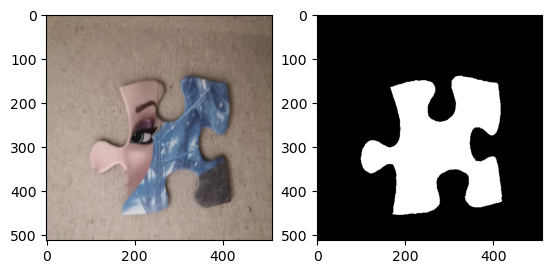

In [3]:
#  list of transformations
# transform_list = [
#     T.RandomHorizontalFlip(),
#     T.RandomVerticalFlip(),
#     T.RandomRotation(30),
# ]


train_dataset = PuzzleDataset(
    img_dir="./images-1024x768/train/",
    mask_dir="./masks-1024x768/train/", 
    transform=True,
    num_transforms=3  
)
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
# note we now have more images since transform applied so maybe adjust batches
train_loader = DataLoader(train_dataset,batch_size =2, shuffle=True)

print(len(train_dataset.data))
# # to visualise the images + masks are in correct pairing
image, mask = train_dataset[6]

image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
mask_np = mask.permute(1, 2, 0).numpy()
print(mask.shape)


#to collapse the separate channels of bg and fg mask
if mask_np.shape[2] == 2:
    mask_np = np.argmax(mask_np, axis=2)
    
plt.figure()
plt.subplot(1,2,1), plt.imshow(image_np)
plt.subplot(1,2,2), plt.imshow(mask_np, cmap="gray")



In [4]:
val_dataset = PuzzleDataset(
    img_dir="./images-1024x768/val/",
    mask_dir="./masks-1024x768/val/", 
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_dataset = PuzzleDataset(img_dir = "./images-1024x768/test/",
                            mask_dir = "./masks-1024x768/test/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
test_loader = DataLoader(test_dataset,batch_size =1, shuffle=False)

# 3.1 Unet Construction
## Add notes on this here (what is happening)

In [5]:
""" Adding checkpoints as required and to avoid training everytime someone wants to test"""
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")


# use as in training
"""save_checkpoint(model, optimizer, epoch)"""


def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from epoch {epoch}.")
        return epoch
    else:
        print("No checkpoint found.")
        return 0  # training from start ...

# before training starts to load model
"""start_epoch = load_checkpoint(model, optimizer)"""


'start_epoch = load_checkpoint(model, optimizer)'

In [6]:
""" helper to clear the gpu of datasets and model"""
def clear_gpu_memory(model=None, data_loaders=None):
    
    if model is not None:
        model.cpu()
        del model
    
    
    if data_loaders is not None:
        for loader in data_loaders:
            del loader  
    
    #  garbage collection
    gc.collect()
    
    torch.cuda.empty_cache()

## Vairant 1 : Using `torch.nn.ConvTranspose2d` for upsampling
- We removed the softmax in the unet with convolve to get to the required number of output classes (ask richard).
- Having the argmax inside the network caused issues with backprop so we only compute the raw logits and use these for the BCE loss
then use the apply softmax outside when performing inference on the test set.

In [7]:
# So this is the triple convolution, chat gpt says we should use normalization dont know if we should keep it
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.triple_conv(x)
    
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.triple_conv(x)

    
# the down module is what the unet uses during the first half 
class Down(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Down, self).__init__()
        self.conv_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            DoubleConv(in_channels,out_channels)
        )

    def forward(self, x):
        ret_ = self.conv_pool(x)
        return ret_

# up transpose, 
class UpConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvTranspose, self).__init__()
        # to determine amount of out channels
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = Conv(out_channels, out_channels)

    def forward(self,x):
        x = self.up(x)
        return self.conv(x)

class UpBilinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBilinear, self).__init__()
        # the bilinear is provided by the nn module, we set the mode to bilinear here
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = Conv(out_channels*2, out_channels)

    def forward(self,x):
        x = self.up(x)
        return self.conv(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels,mode):
        super(Up, self).__init__()
        if(mode=='convtranspose'):
            self.conv_pool = nn.Sequential(
                UpConvTranspose(in_channels,out_channels),
                Conv(out_channels,out_channels)
            )
        else:
            self.conv_pool = nn.Sequential(
                UpBilinear(in_channels,out_channels),
                Conv(out_channels,out_channels)
            )
        
        self.dconv = DoubleConv(out_channels*2,out_channels)
    
    def forward(self,x1,x2):
        x = self.conv_pool(x1)
        return self.dconv(torch.cat([x,x2],dim=1))

    
class SoftMax(nn.Module):
    def __init__(self, in_channels):
        super(SoftMax, self).__init__()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.softmax(x)
        return torch.argmax(x,dim=1)

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, variant=None):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.variant = variant

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64,128)
        self.down2 = Down(128,256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,1024)
        
        self.up1 = Up(1024,512,variant)
        self.up2 = Up(512, 256,variant)
        self.up3 = Up(256, 128,variant)
        self.up4 = Up(128, 64,variant)

        self.outc = nn.Conv2d(64,2, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits
    

In [8]:
def calculate_iou(preds, targets, threshold=0.5):
    
    if preds.dim() == 3:
        preds = preds.unsqueeze(0)  
    if targets.dim() == 3:
        targets = targets.unsqueeze(0) 

    preds = (torch.sigmoid(preds) > threshold).float()
    
    
    intersection = torch.sum(preds * targets, dim=[2, 3])
    union = torch.sum(preds, dim=[2, 3]) + torch.sum(targets, dim=[2, 3]) - intersection
    
    #  IoU
    iou = (intersection + 1e-6) / (union + 1e-6)  
    
    return iou.mean().item()

NOTE: I just pushed to the cpu when I try putting the model on the gpu I get weird errors in training 
that I used up all the GPU memory maybe you wont get this error then just comment out `device="cpu"
`

In [10]:
import wandb
print(wandb.__version__)


0.16.6


In [9]:
""" Training UNET Variant 1
    torch.nn.ConvTranspose2d """

import gc
import wandb
wandb.init(project="OUR_UNET", name="Convtranspose")

# I forced the device to cpu since I have no gpu comment that line out!

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")



# Model, criterion, and optimizer setup
model = Unet(n_channels=3, n_classes=2, variant='convtranspose')

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model = model.to('cuda:1')

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#  checkpoints if any
start_epoch = load_checkpoint(model, optimizer, filename="var1_checkpoint.pth")

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(start_epoch, num_epochs):
    
    # print(torch.cuda.memory_summary())

    
    model.train()  
    running_loss = 0.0
    train_iou = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        # outputs = outputs.float()
        # outputs = torch.softmax(outputs, dim=1)

        # print(f"Outputs min: {outputs.min()}, max: {outputs.max()}, shape: {outputs.shape}")
        # print(f"Masks min: {masks.min()}, max: {masks.max()}, shape: {masks.shape}")
        
        # BCE loss with logits 
        loss = criterion(outputs, masks)
        loss.backward()
        #gradient clipping I dunno why we get nans
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        #softmax to logits to then get the IoU
        
        
        #  loss and IoU
        running_loss += loss.item()
        train_iou += calculate_iou(outputs, masks)

    train_loss = running_loss / len(train_loader)
    train_iou = train_iou / len(train_loader)

    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            val_iou += calculate_iou(outputs, masks)

    val_loss = val_loss / len(val_loader)
    val_iou = val_iou/ len(val_loader)


    #  training and validation metrics to wandb
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "train_iou": train_iou, "val_iou": val_iou})
    
    
    # print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    
    # store model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(model,optimizer, epoch, "var1_checkpoint.pth")
       # print(f"Checkpoint saved at epoch {epoch + 1}")

    # model.cpu()
    # del model
    gc.collect() 
    torch.cuda.empty_cache()
    
    # print(torch.cuda.memory_summary())


# close wandb run


# run tensorboard --logdir=runs to see networkls


wandb: Currently logged in as: 2322203 (2322203-witwatersrand-university). Use `wandb login --relogin` to force relogin


Device: cuda


/tmp/ipykernel_2101873/3703089074.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 48.
Checkpoint saved at epoch 48.


In [10]:
def display_tensor_as_image(tensor, channel_num, channel_index, height_index, width_index):
    # Move the tensor to CPU and convert it to a NumPy array
    tensor_np = tensor.cpu().numpy()
    if channel_index == 1:
        tensor_np = tensor_np.squeeze(0)

        channel_index -=1
        height_index-=1
        width_index-=1
        
    # Handle single-channel (grayscale) image
    if channel_num == 1:
        image_np = tensor_np.squeeze(channel_index)  # Remove the channel dimension
        plt.imshow(image_np, cmap="gray")
        plt.title("Single-channel image")
        plt.show()
    
    # Handle two-channel image (display channels separately)
    elif channel_num == 2:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create 1 row, 2 columns
        for i in range(2):
            channel_image = tensor_np[i]  # Select each channel (e.g., 0 and 1)
            axes[i].imshow(channel_image, cmap="gray")
            axes[i].set_title(f"Channel {i}")
            # print(f"Max value in channel {i}:", np.max(channel_image))
            # print(f"Min value in channel {i}:", np.min(channel_image))
        plt.show()
    
    # Handle three-channel image (RGB)
    elif channel_num == 3:
        print(tensor_np.shape)
        # Transpose from (channels, height, width) to (height, width, channels)
        image_np = np.transpose(tensor_np, (height_index, width_index, channel_index))
        plt.imshow(image_np)
        plt.title("Three-channel image (RGB)")
        plt.show()


In [13]:
""" USING THIS ONE FOR IOU THE ONE ABOVE USED A SIGMOID BECAUSE OF MODEL TRAINING ISSUES BUT HERE WE USE A SOFTMAX"""


import torchmetrics.functional as tmf


In [14]:
def evaluate_model_on_test_loader(model, test_loader, device, show_plot=True):
    model.eval() 
    total_iou = 0.0
    total_accuracy = 0.0
    total_precision = 0.0
    total_recall = 0.0
    total_f1 = 0.0
    num_samples = 0

    with torch.no_grad():
        for idx, (image, mask) in enumerate(test_loader):
            images = image.to(device)
            masks = mask.to(device)  
            
            outputs = model(images)

            #softmax and argmax for predictions
            probs = torch.softmax(outputs, dim=1)
            predicted_mask = torch.argmax(probs, dim=1)  

          
            masks_foreground = masks[:, 1, :, :]  

            
            predicted_mask_binary = (predicted_mask > 0).float()  
            masks_foreground_binary = (masks_foreground > 0).float() 

           
            iou = tmf.jaccard_index(predicted_mask_binary, masks_foreground_binary, task="binary", num_classes=2)
            total_iou += iou.item()

            #metrics to be printed!
            accuracy = tmf.accuracy(predicted_mask_binary, masks_foreground_binary, task="binary", num_classes=2)
            precision = tmf.precision(predicted_mask_binary, masks_foreground_binary, task="binary", num_classes=2, average='macro')
            recall = tmf.recall(predicted_mask_binary, masks_foreground_binary, task="binary", num_classes=2, average='macro')
            f1 = tmf.f1_score(predicted_mask_binary, masks_foreground_binary, task="binary", num_classes=2, average='macro')

            
            total_accuracy += accuracy.item()
            total_precision += precision.item()
            total_recall += recall.item()
            total_f1 += f1.item()

            num_samples += 1

           
            if show_plot:
                
                images_np = images.squeeze().cpu().numpy().transpose(1, 2, 0)  
                
               
                masks_np = masks.squeeze().cpu().numpy()[1] 
                predicted_mask_np = predicted_mask.squeeze().cpu().numpy()  
            
                wandb.log({
                    f"Test Image {idx}": [
                        wandb.Image(images_np, caption=f"Original Image {idx}"),
                        wandb.Image(masks_np, caption=f"Ground Truth Mask {idx}"),
                        wandb.Image(predicted_mask_np, caption=f"Predicted Mask {idx}")
                    ]
                })
            


    # mean metrics
    mean_iou = total_iou / num_samples 
    mean_accuracy = total_accuracy / num_samples 
    mean_precision = total_precision / num_samples 
    mean_recall = total_recall / num_samples 
    mean_f1 = total_f1 / num_samples 

    
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Accuracy: {mean_accuracy:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1 Score: {mean_f1:.4f}")
    
    wandb.log({"test_mean_iou": mean_iou})
    
    return mean_iou


# Testing the model


In [15]:

#del model
model = Unet(n_channels=3, n_classes=2, variant='convtranspose')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

load_checkpoint(model, optimizer, filename="var1_checkpoint.pth")

mean_iou = evaluate_model_on_test_loader(model, test_loader, device, show_plot=True)
wandb.log({"test_mean_iou": mean_iou})
wandb.finish()
""" DELETING THE MODEL HERE TO FREE UP VRAM!!!!
 BUT ALSO so i dont have rename the model variable from the  previous block in later sections"""
clear_gpu_memory(model, [train_loader, val_loader, test_loader])


/tmp/ipykernel_2101873/3703089074.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 48.
Mean IoU: 0.9765
Mean Accuracy: 0.9939
Mean Precision: 0.9883
Mean Recall: 0.9878
Mean F1 Score: 0.9881


# outputs from Conv Transpose:

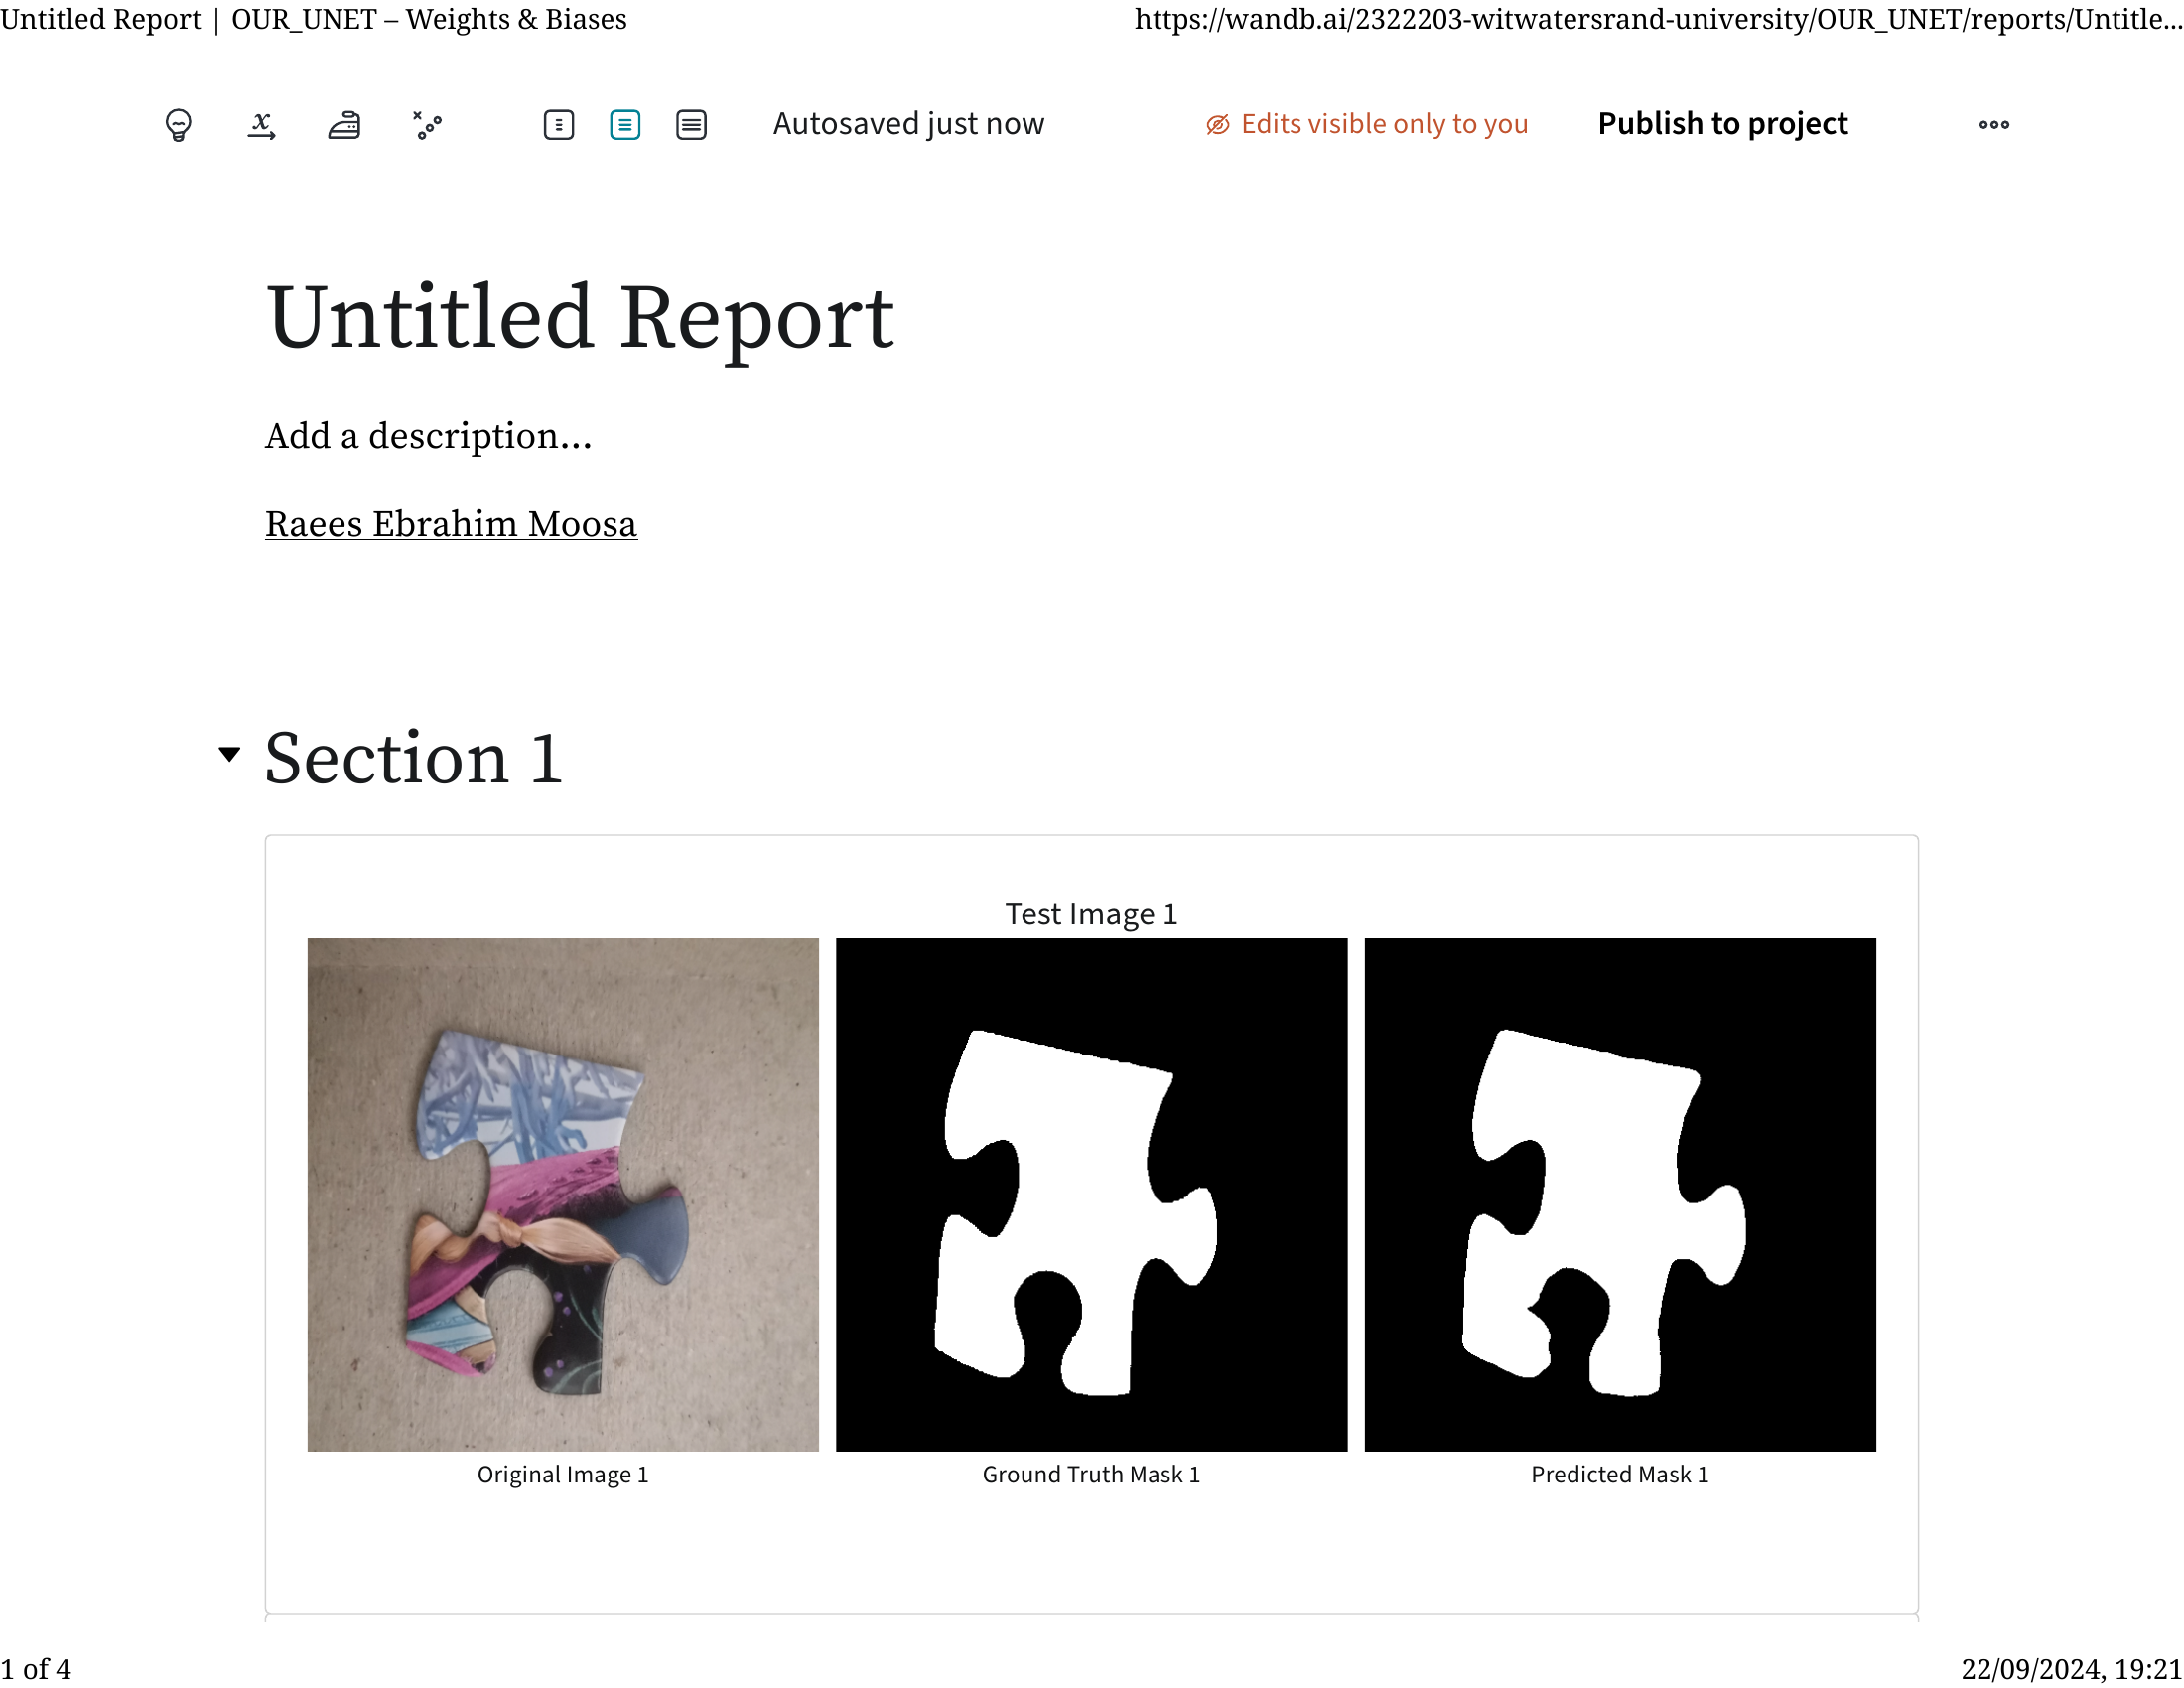

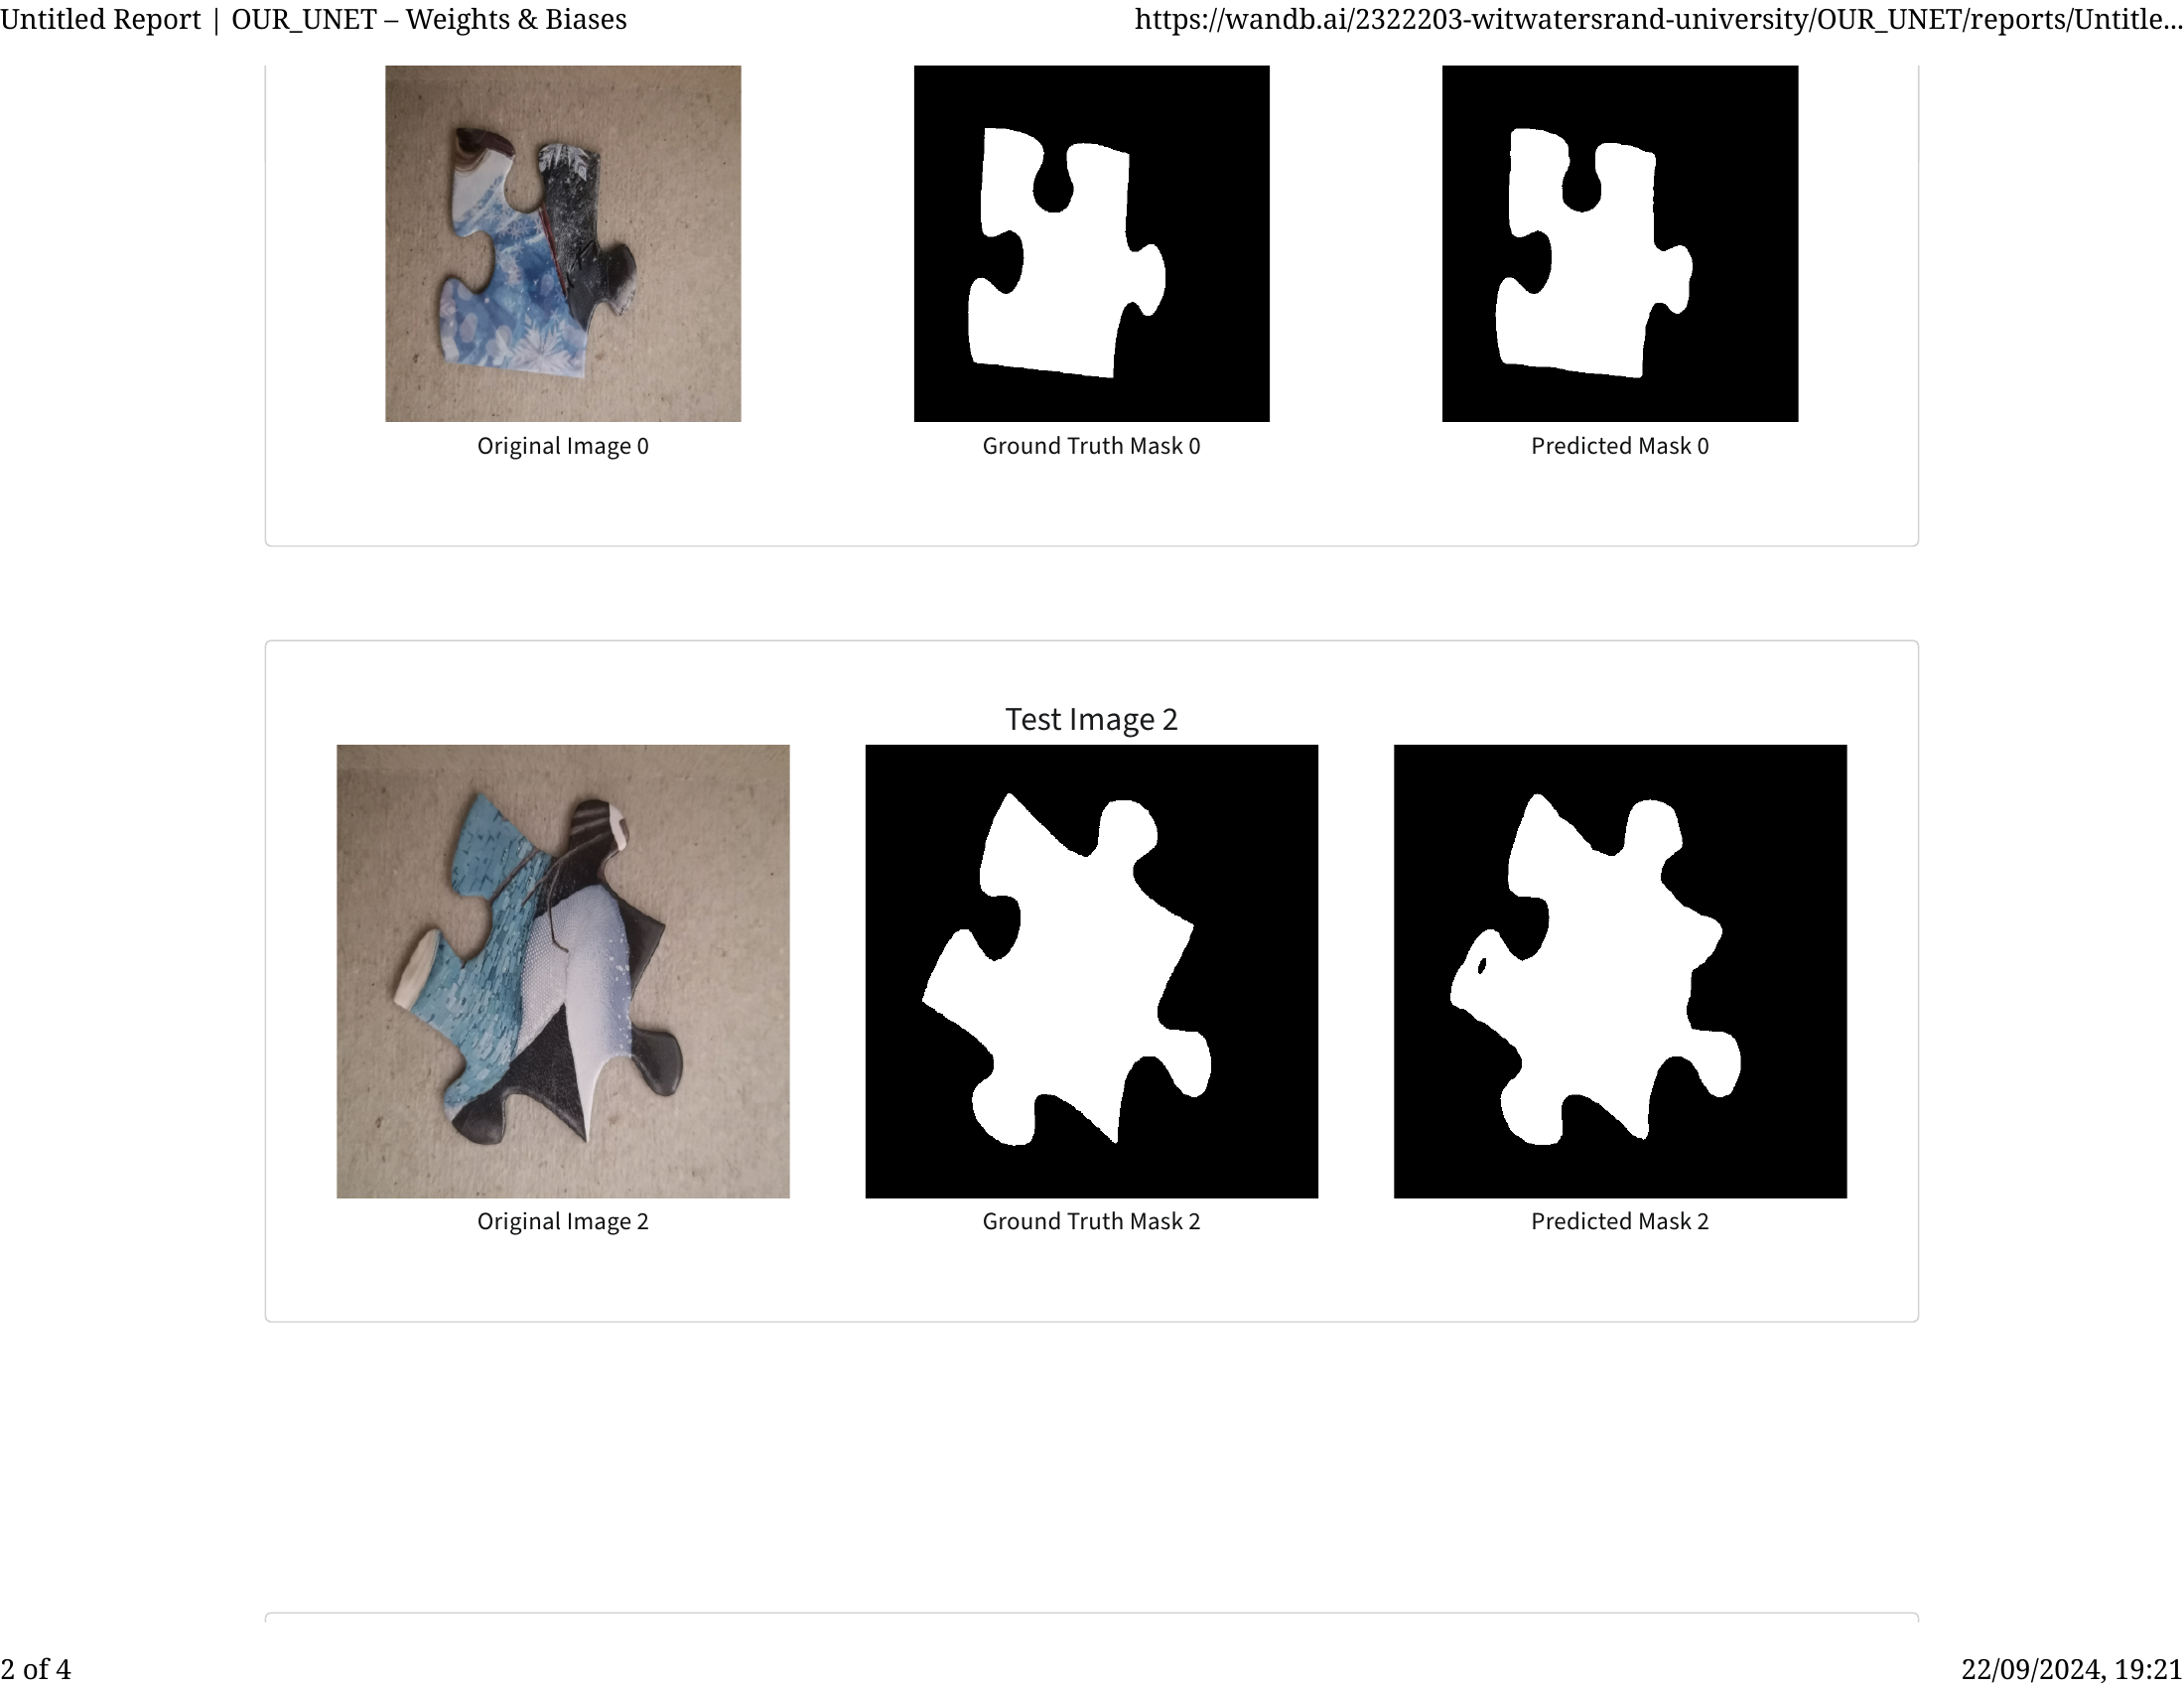

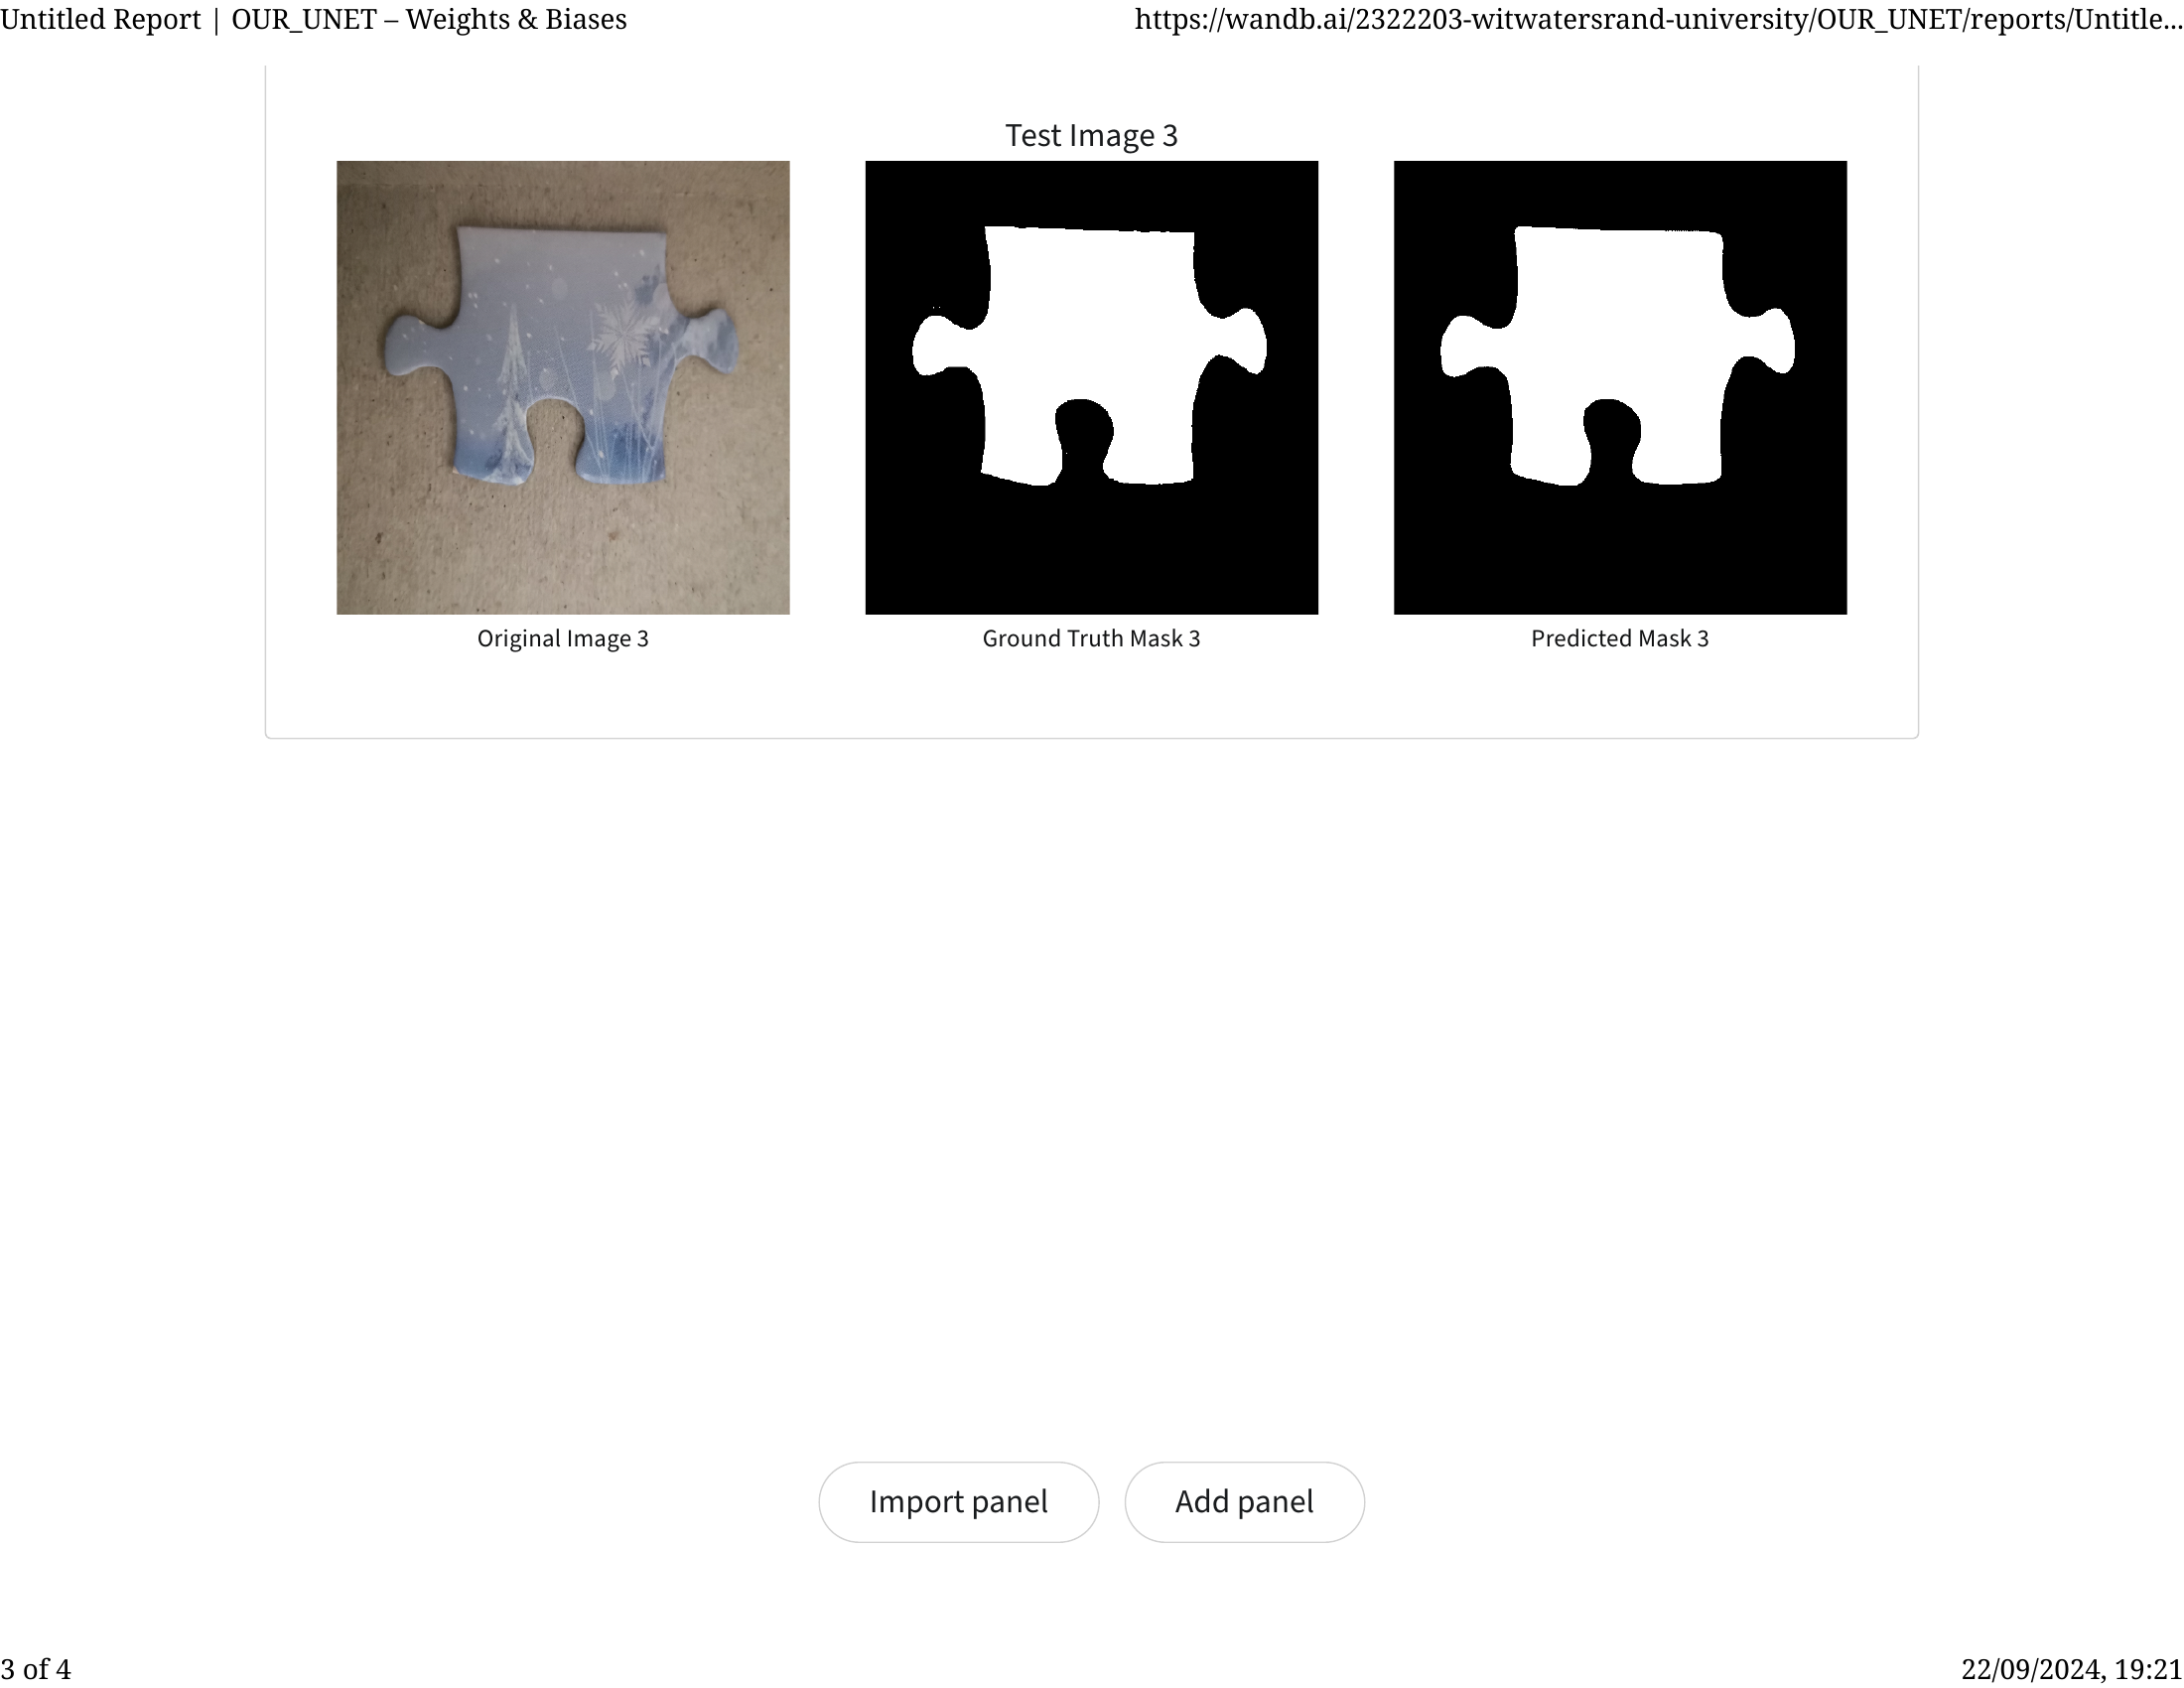

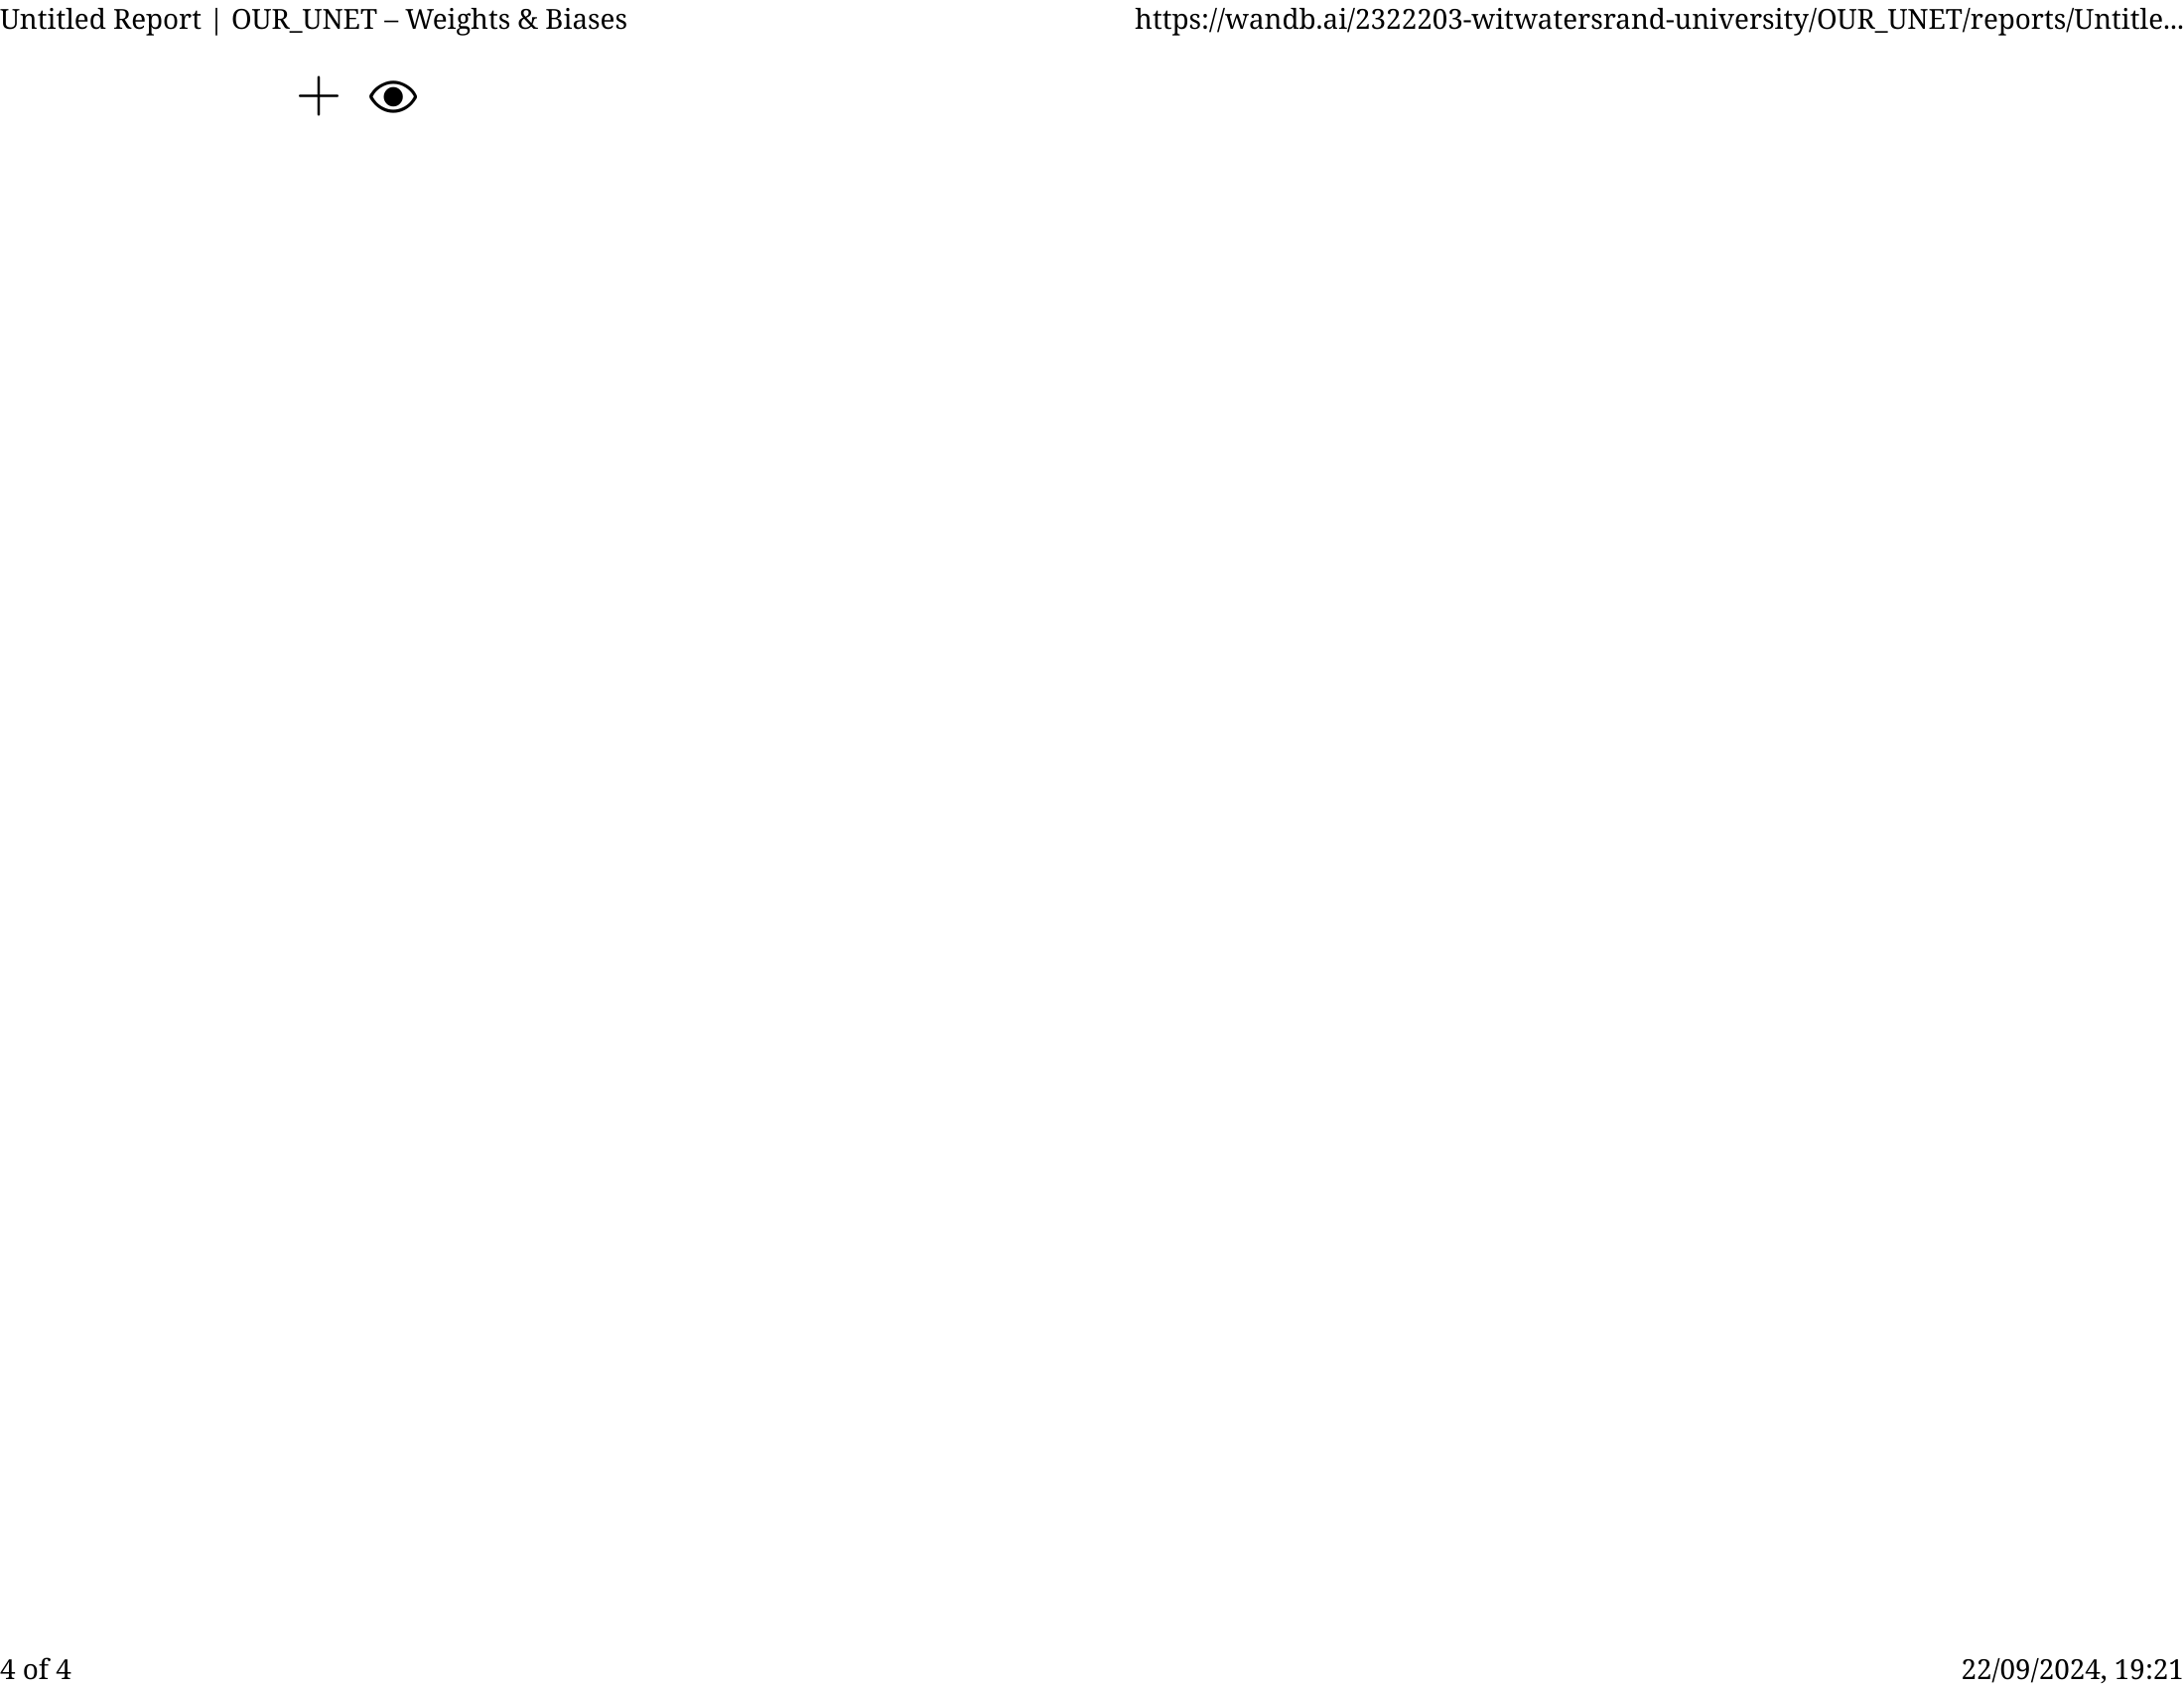

In [19]:
from pdf2image import convert_from_path
from IPython.display import display

images = convert_from_path('./wandb_logs/conv_tests.pdf')

for image in images:
    display(image)

## Vairant 2: Using `torch.nn.Upsample` for bilinear upsampling

In [16]:
gc.collect()
wandb.init(project="OUR_UNET", name= "bilinear_upsampling")
train_dataset = PuzzleDataset(
    img_dir="./images-1024x768/train/",
    mask_dir="./masks-1024x768/train/", 
    transform=True,
    num_transforms=3  
)
train_loader = DataLoader(train_dataset,batch_size =2, shuffle=True)
val_dataset = PuzzleDataset(
    img_dir="./images-1024x768/val/",
    mask_dir="./masks-1024x768/val/", 
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_dataset = PuzzleDataset(img_dir = "./images-1024x768/test/",
                            mask_dir = "./masks-1024x768/test/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
test_loader = DataLoader(test_dataset,batch_size =1, shuffle=True)


model = Unet(n_channels=3, n_classes=2,variant='upsampling')

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model = model.to('cuda:1')
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#  checkpoints if any
start_epoch = load_checkpoint(model, optimizer, filename="var2_checkpoint.pth")

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(start_epoch, num_epochs):
    
    # print(torch.cuda.memory_summary())

    
    model.train()  
    running_loss = 0.0
    train_iou = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        # outputs = outputs.float()
        # outputs = torch.softmax(outputs, dim=1)

        # print(f"Outputs min: {outputs.min()}, max: {outputs.max()}, shape: {outputs.shape}")
        # print(f"Masks min: {masks.min()}, max: {masks.max()}, shape: {masks.shape}")
        
        # BCE loss with logits 
        loss = criterion(outputs, masks)
        loss.backward()
        #gradient clipping I dunno why we get nans
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        
        
        #  loss and IoU
        running_loss += loss.item()
        train_iou += calculate_iou(outputs, masks)

    train_loss = running_loss / len(train_loader)
    train_iou = train_iou/ len(train_loader)

    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            val_iou += calculate_iou(outputs, masks)

    val_loss = val_loss / len(val_loader)
    val_iou = val_iou /len(val_loader)


    #  training and validation metrics to wandb
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "train_iou": train_iou, "val_iou": val_iou})
    
    
    # print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    
    # store model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(model,optimizer, epoch, "var2_checkpoint.pth")
        #print(f"Checkpoint saved at epoch {epoch + 1}")

    # model.cpu()
    # del model
    gc.collect() 
    torch.cuda.empty_cache()
    
    # print(torch.cuda.memory_summary())




/tmp/ipykernel_2101873/3703089074.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 33.
Checkpoint saved at epoch 33.
Checkpoint saved at epoch 34.
Checkpoint saved at epoch 35.


# Testing the second base variant here:

In [17]:
test_dataset = PuzzleDataset(img_dir = "./images-1024x768/test/",
                            mask_dir = "./masks-1024x768/test/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
test_loader = DataLoader(test_dataset,batch_size =1, shuffle=False)


del model
model = Unet(n_channels=3, n_classes=2,variant='upsampling')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

load_checkpoint(model, optimizer, filename="var2_checkpoint.pth")

mean_iou = evaluate_model_on_test_loader(model, test_loader, device, show_plot=True)
wandb.log({"test_mean_iou": mean_iou})
wandb.finish()
""" DELETING THE MODEL HERE TO FREE UP VRAM!!!!
 BUT ALSO so i dont have rename the model variable from the  previous block in later sections"""
clear_gpu_memory(model, [train_loader, val_loader, test_loader])


/tmp/ipykernel_2101873/3703089074.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 35.
Mean IoU: 0.9787
Mean Accuracy: 0.9945
Mean Precision: 0.9842
Mean Recall: 0.9943
Mean F1 Score: 0.9892


# Image predictions


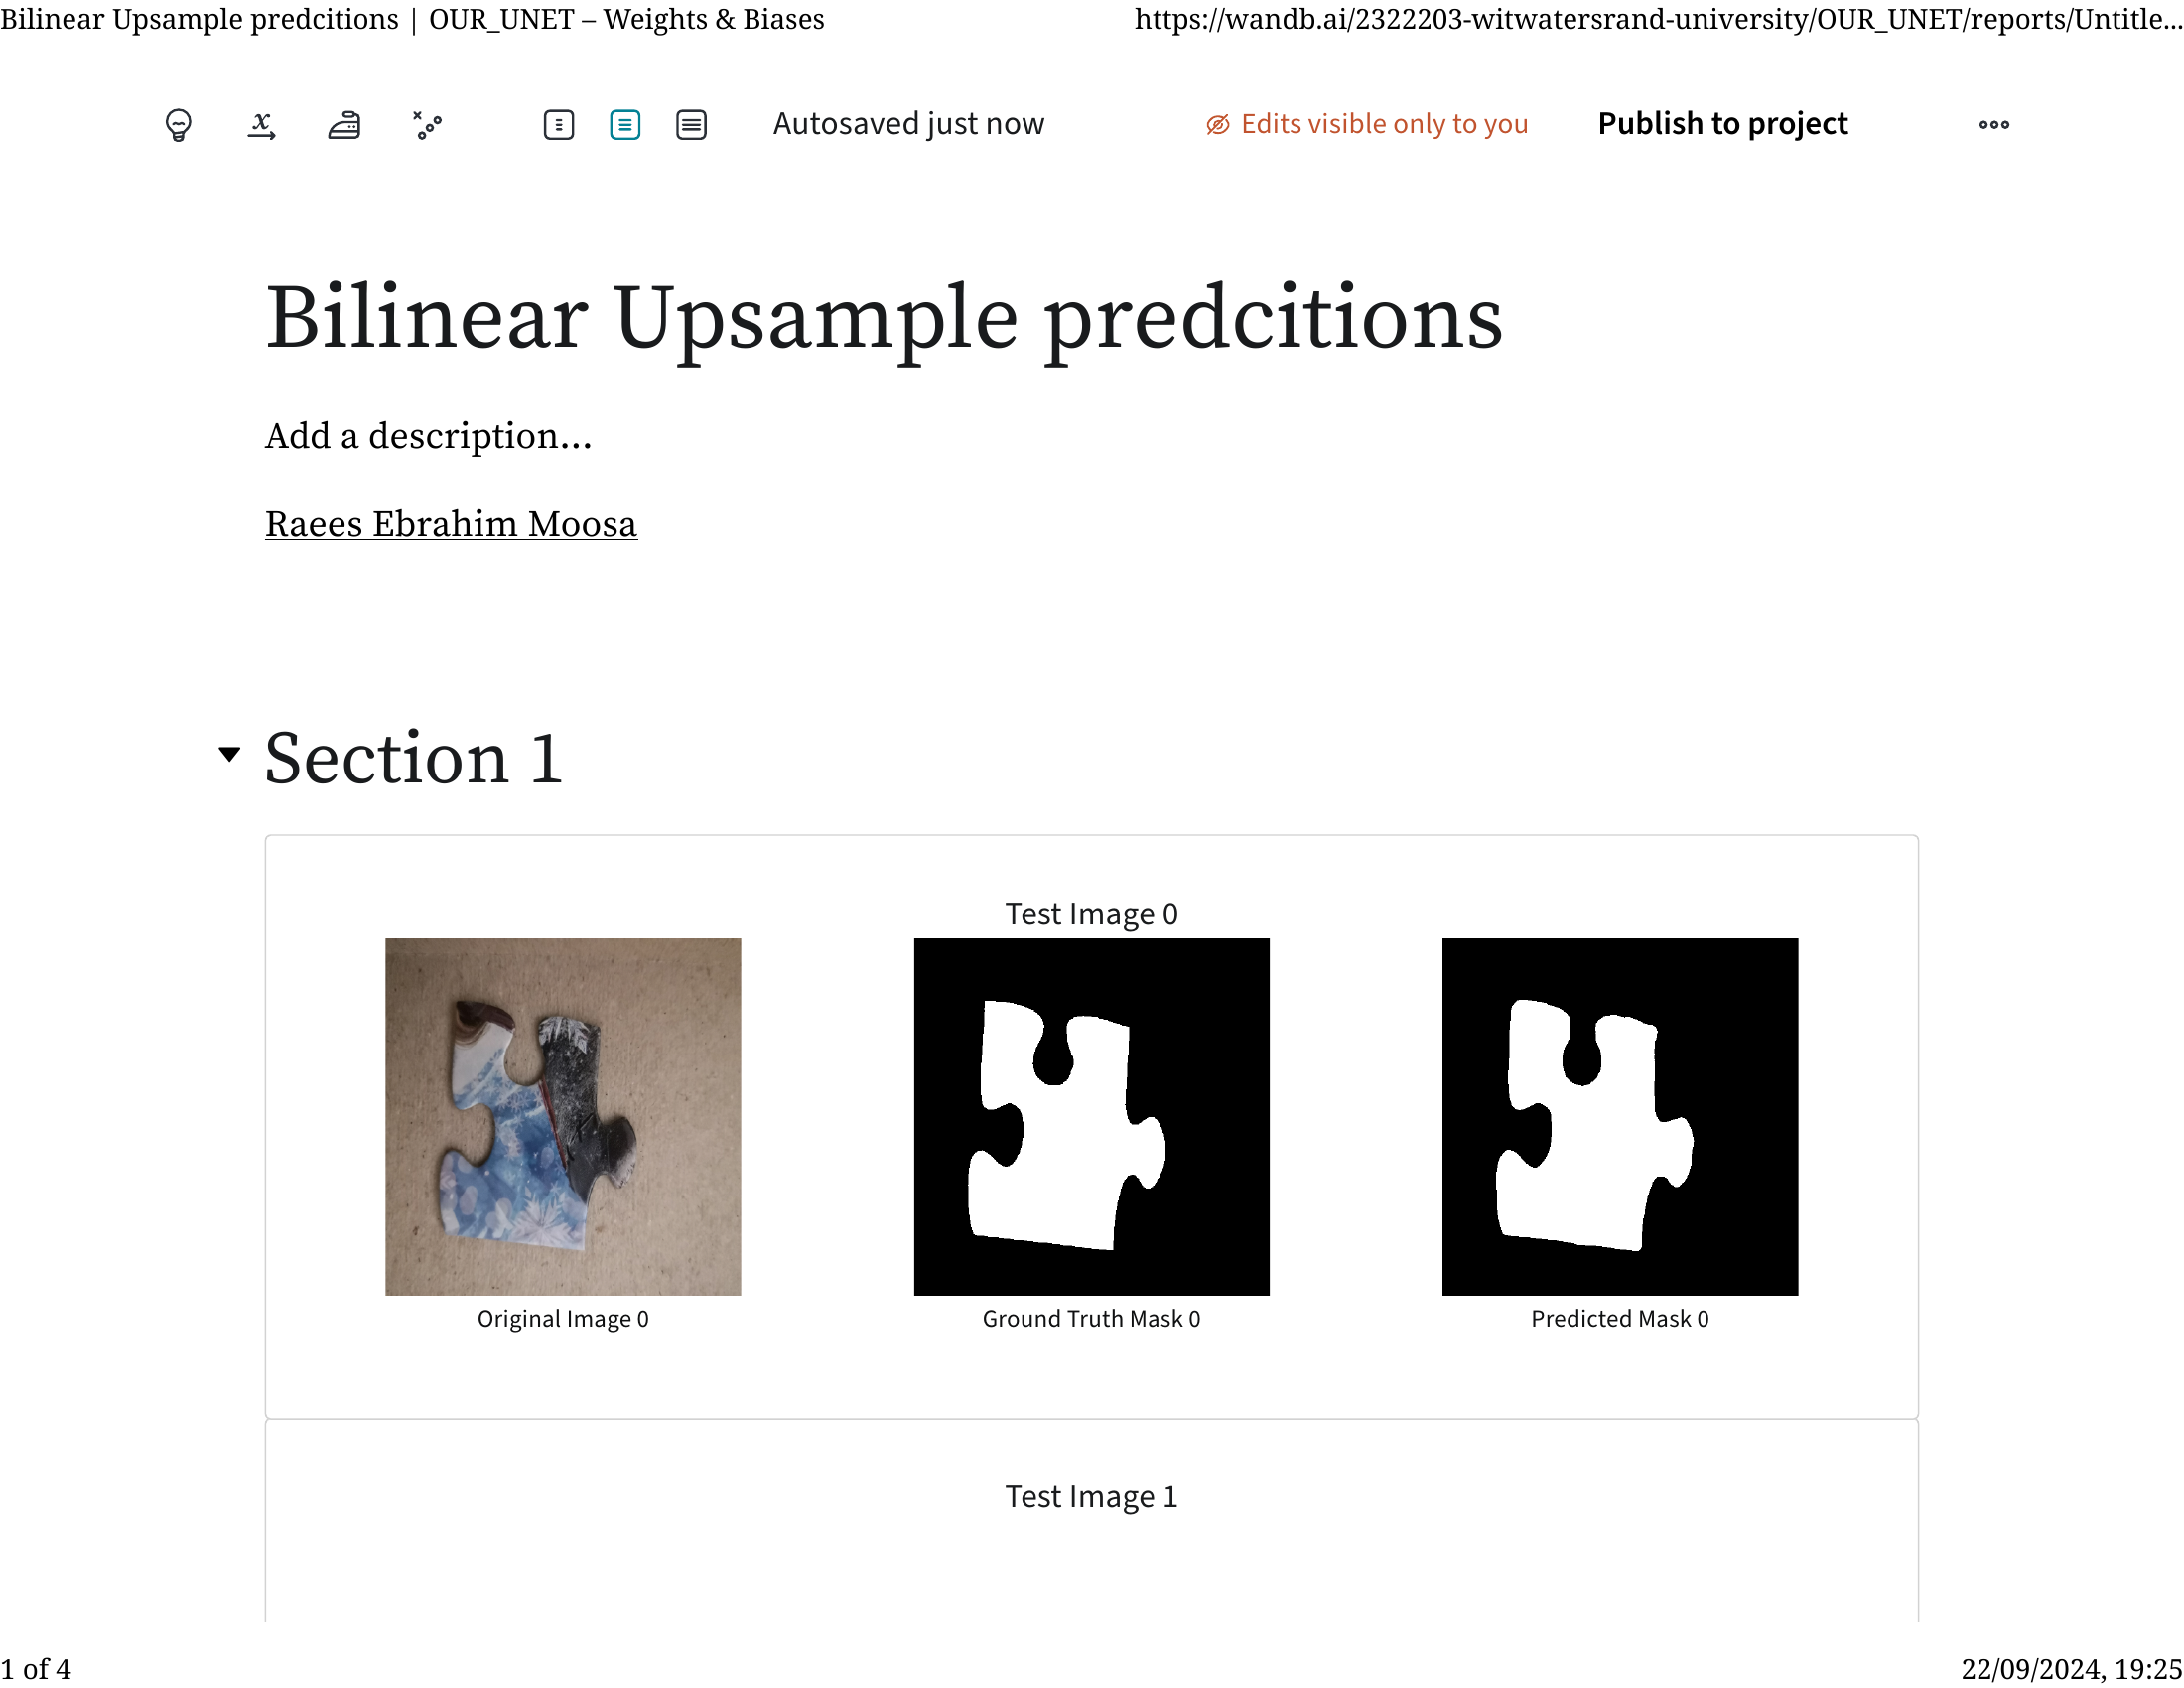

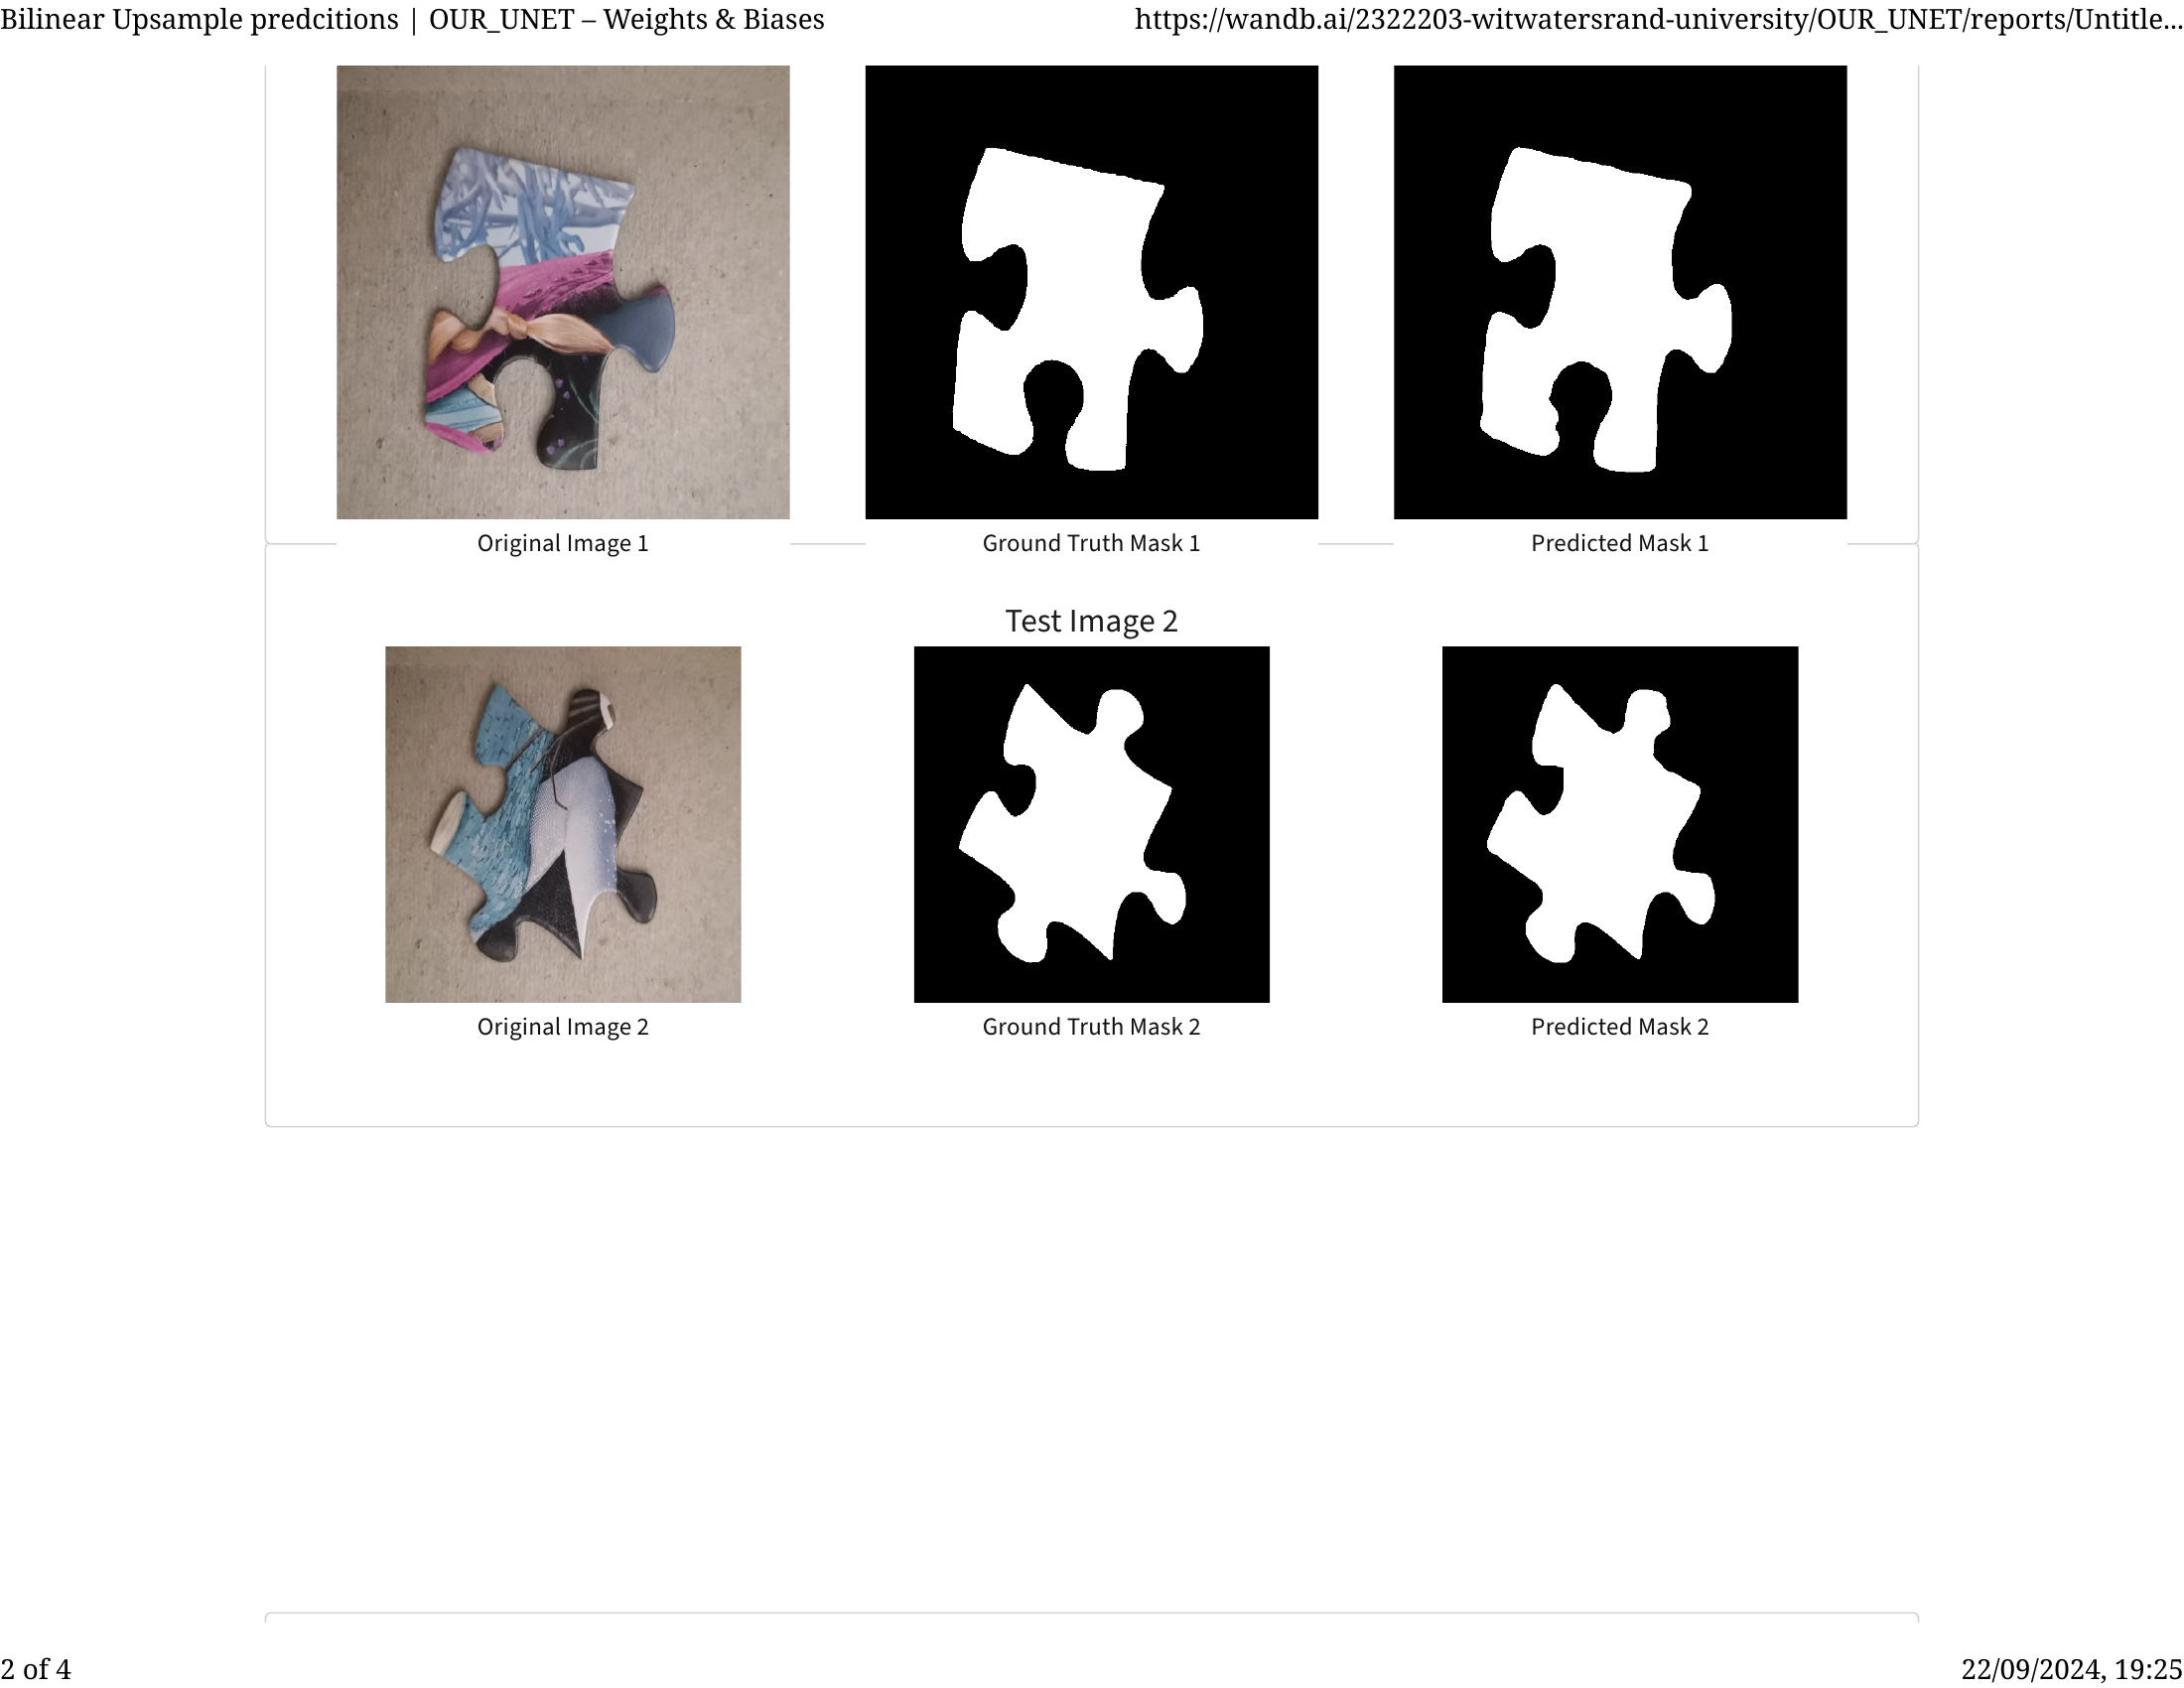

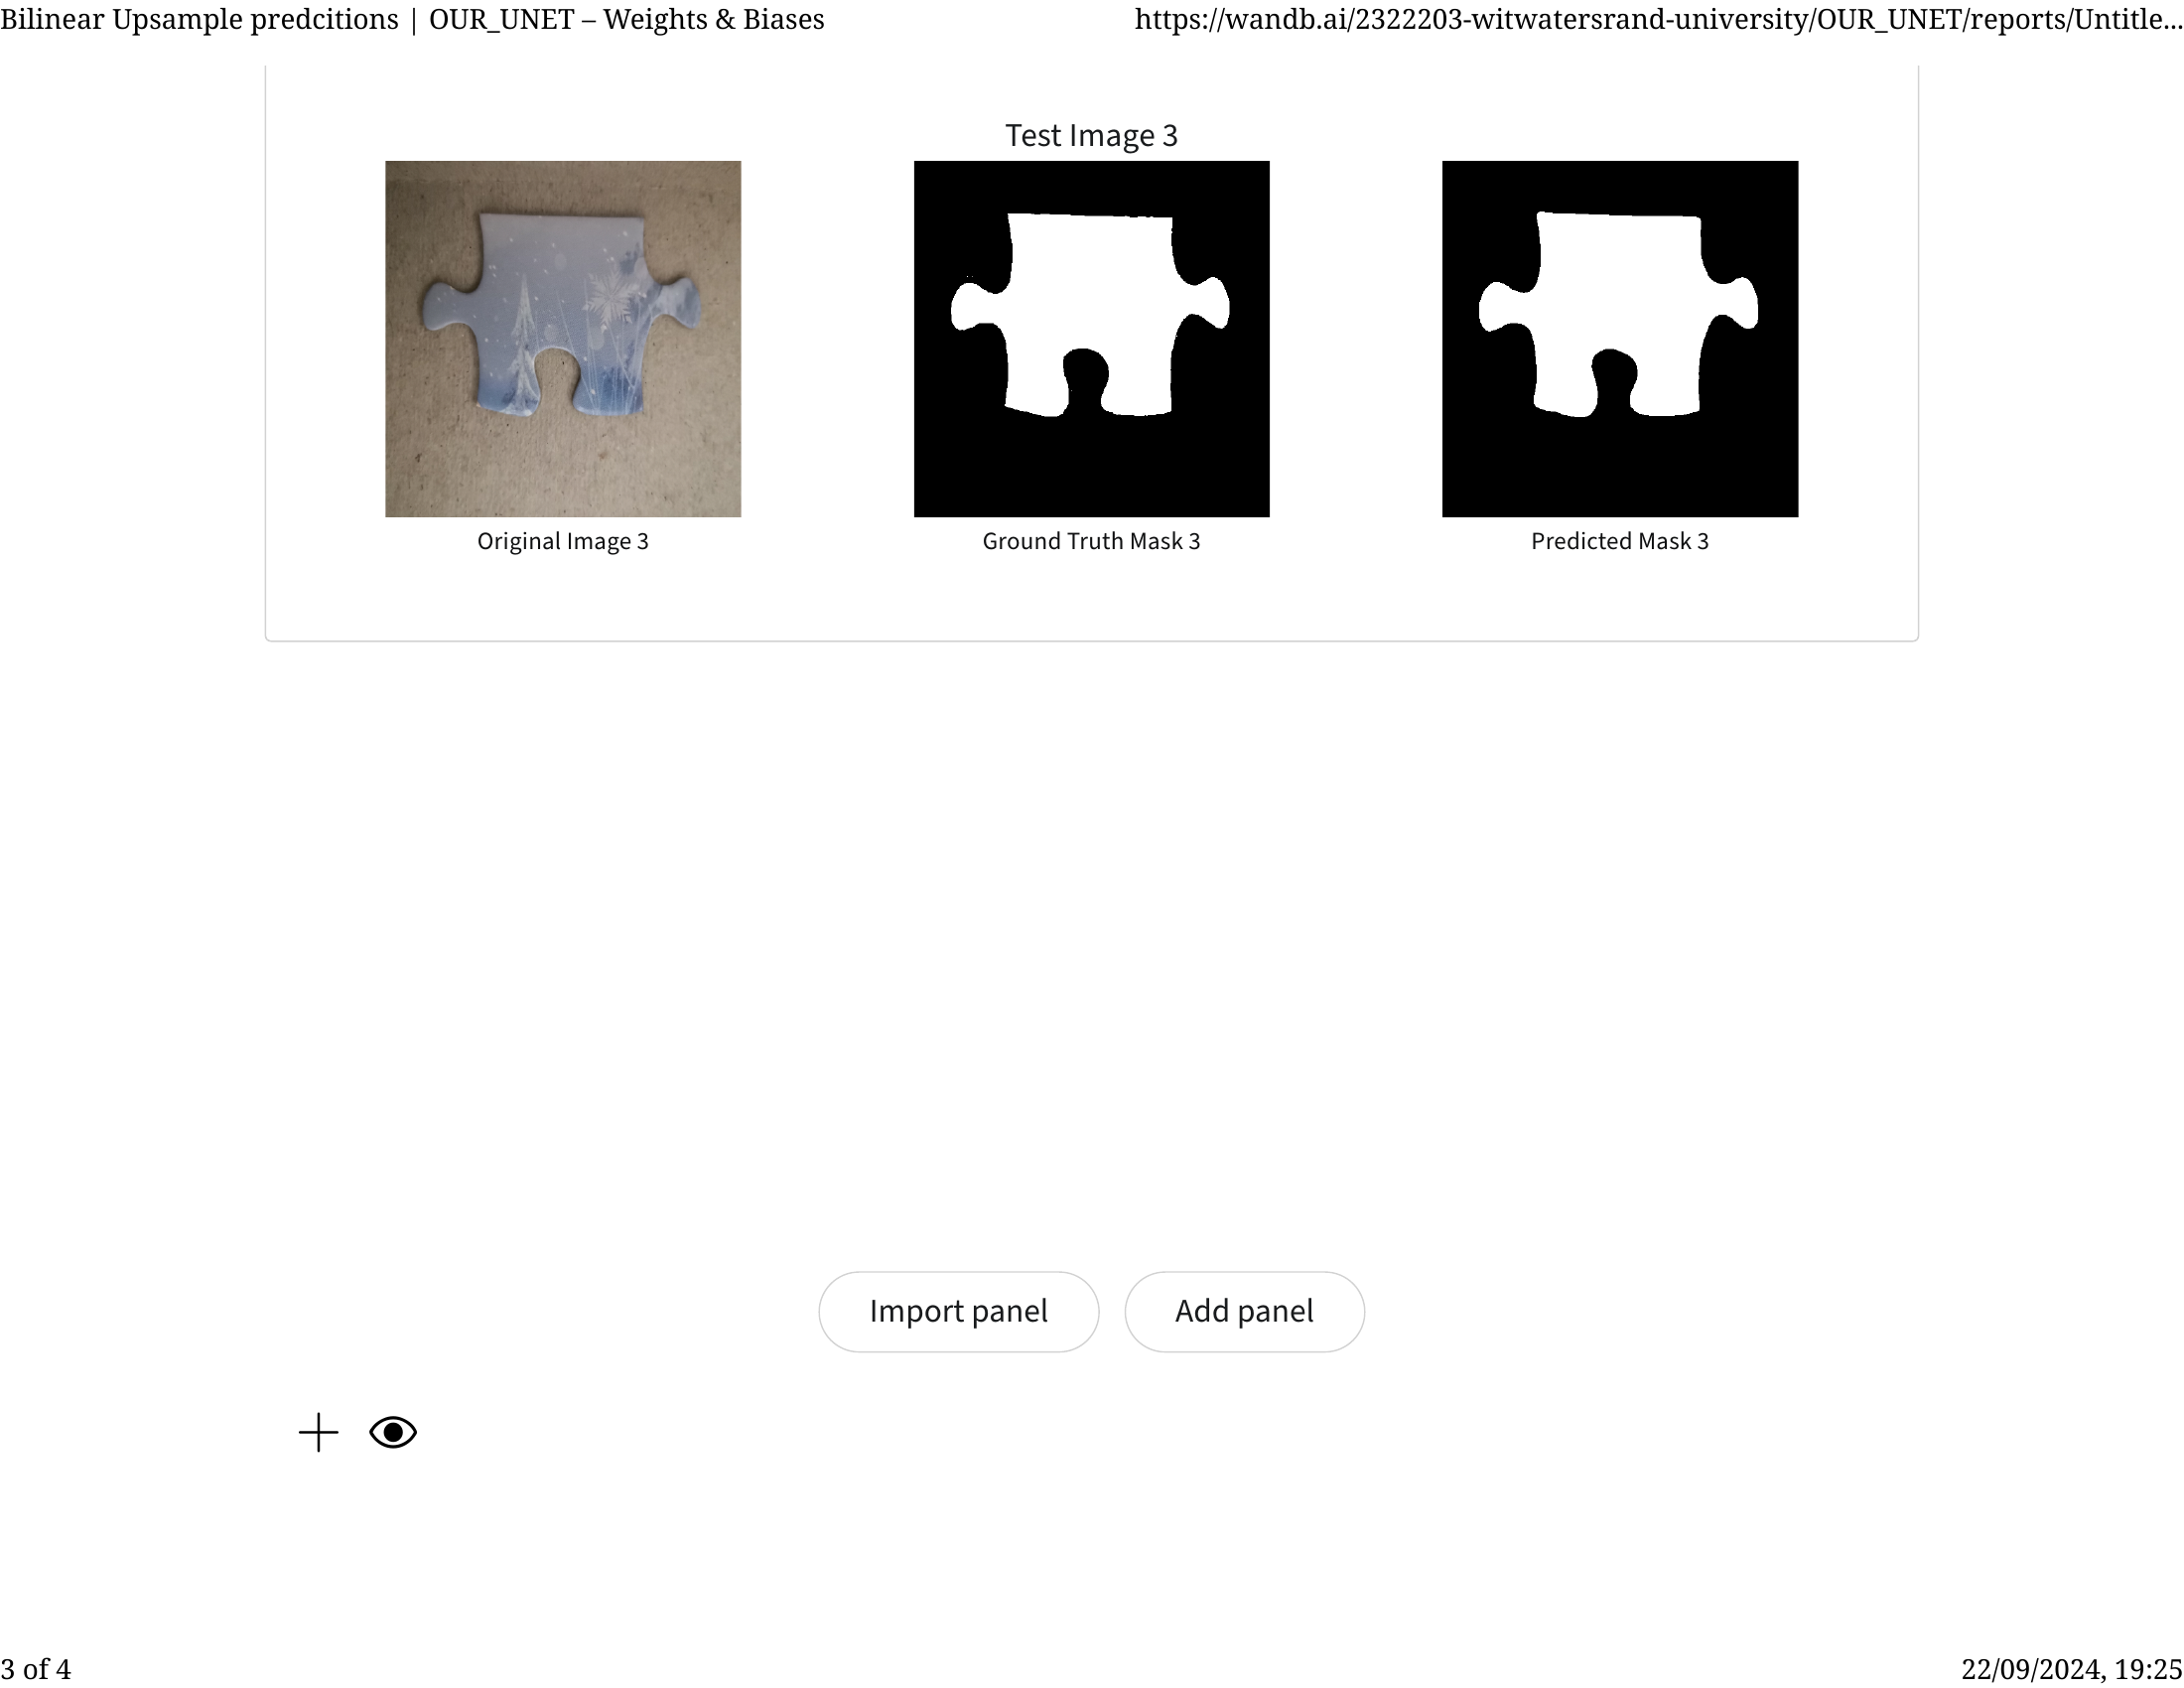

In [20]:
from pdf2image import convert_from_path
from IPython.display import display

images = convert_from_path('./wandb_logs/bi_tests.pdf')

for image in images:
    display(image)

### Evaluation
evaluate model on test set 
- accuracy
- precision
- recall
- F1 score
- IoU
# Note These are all logged in the wandb report which will be attached to this submission!

# Select the best model based on the validation IoU and report its performance on the test set

# The Scores for training both models
Note that the red graph is the Bilinear Upsampling method and the blue graph is the ConvTranspose method

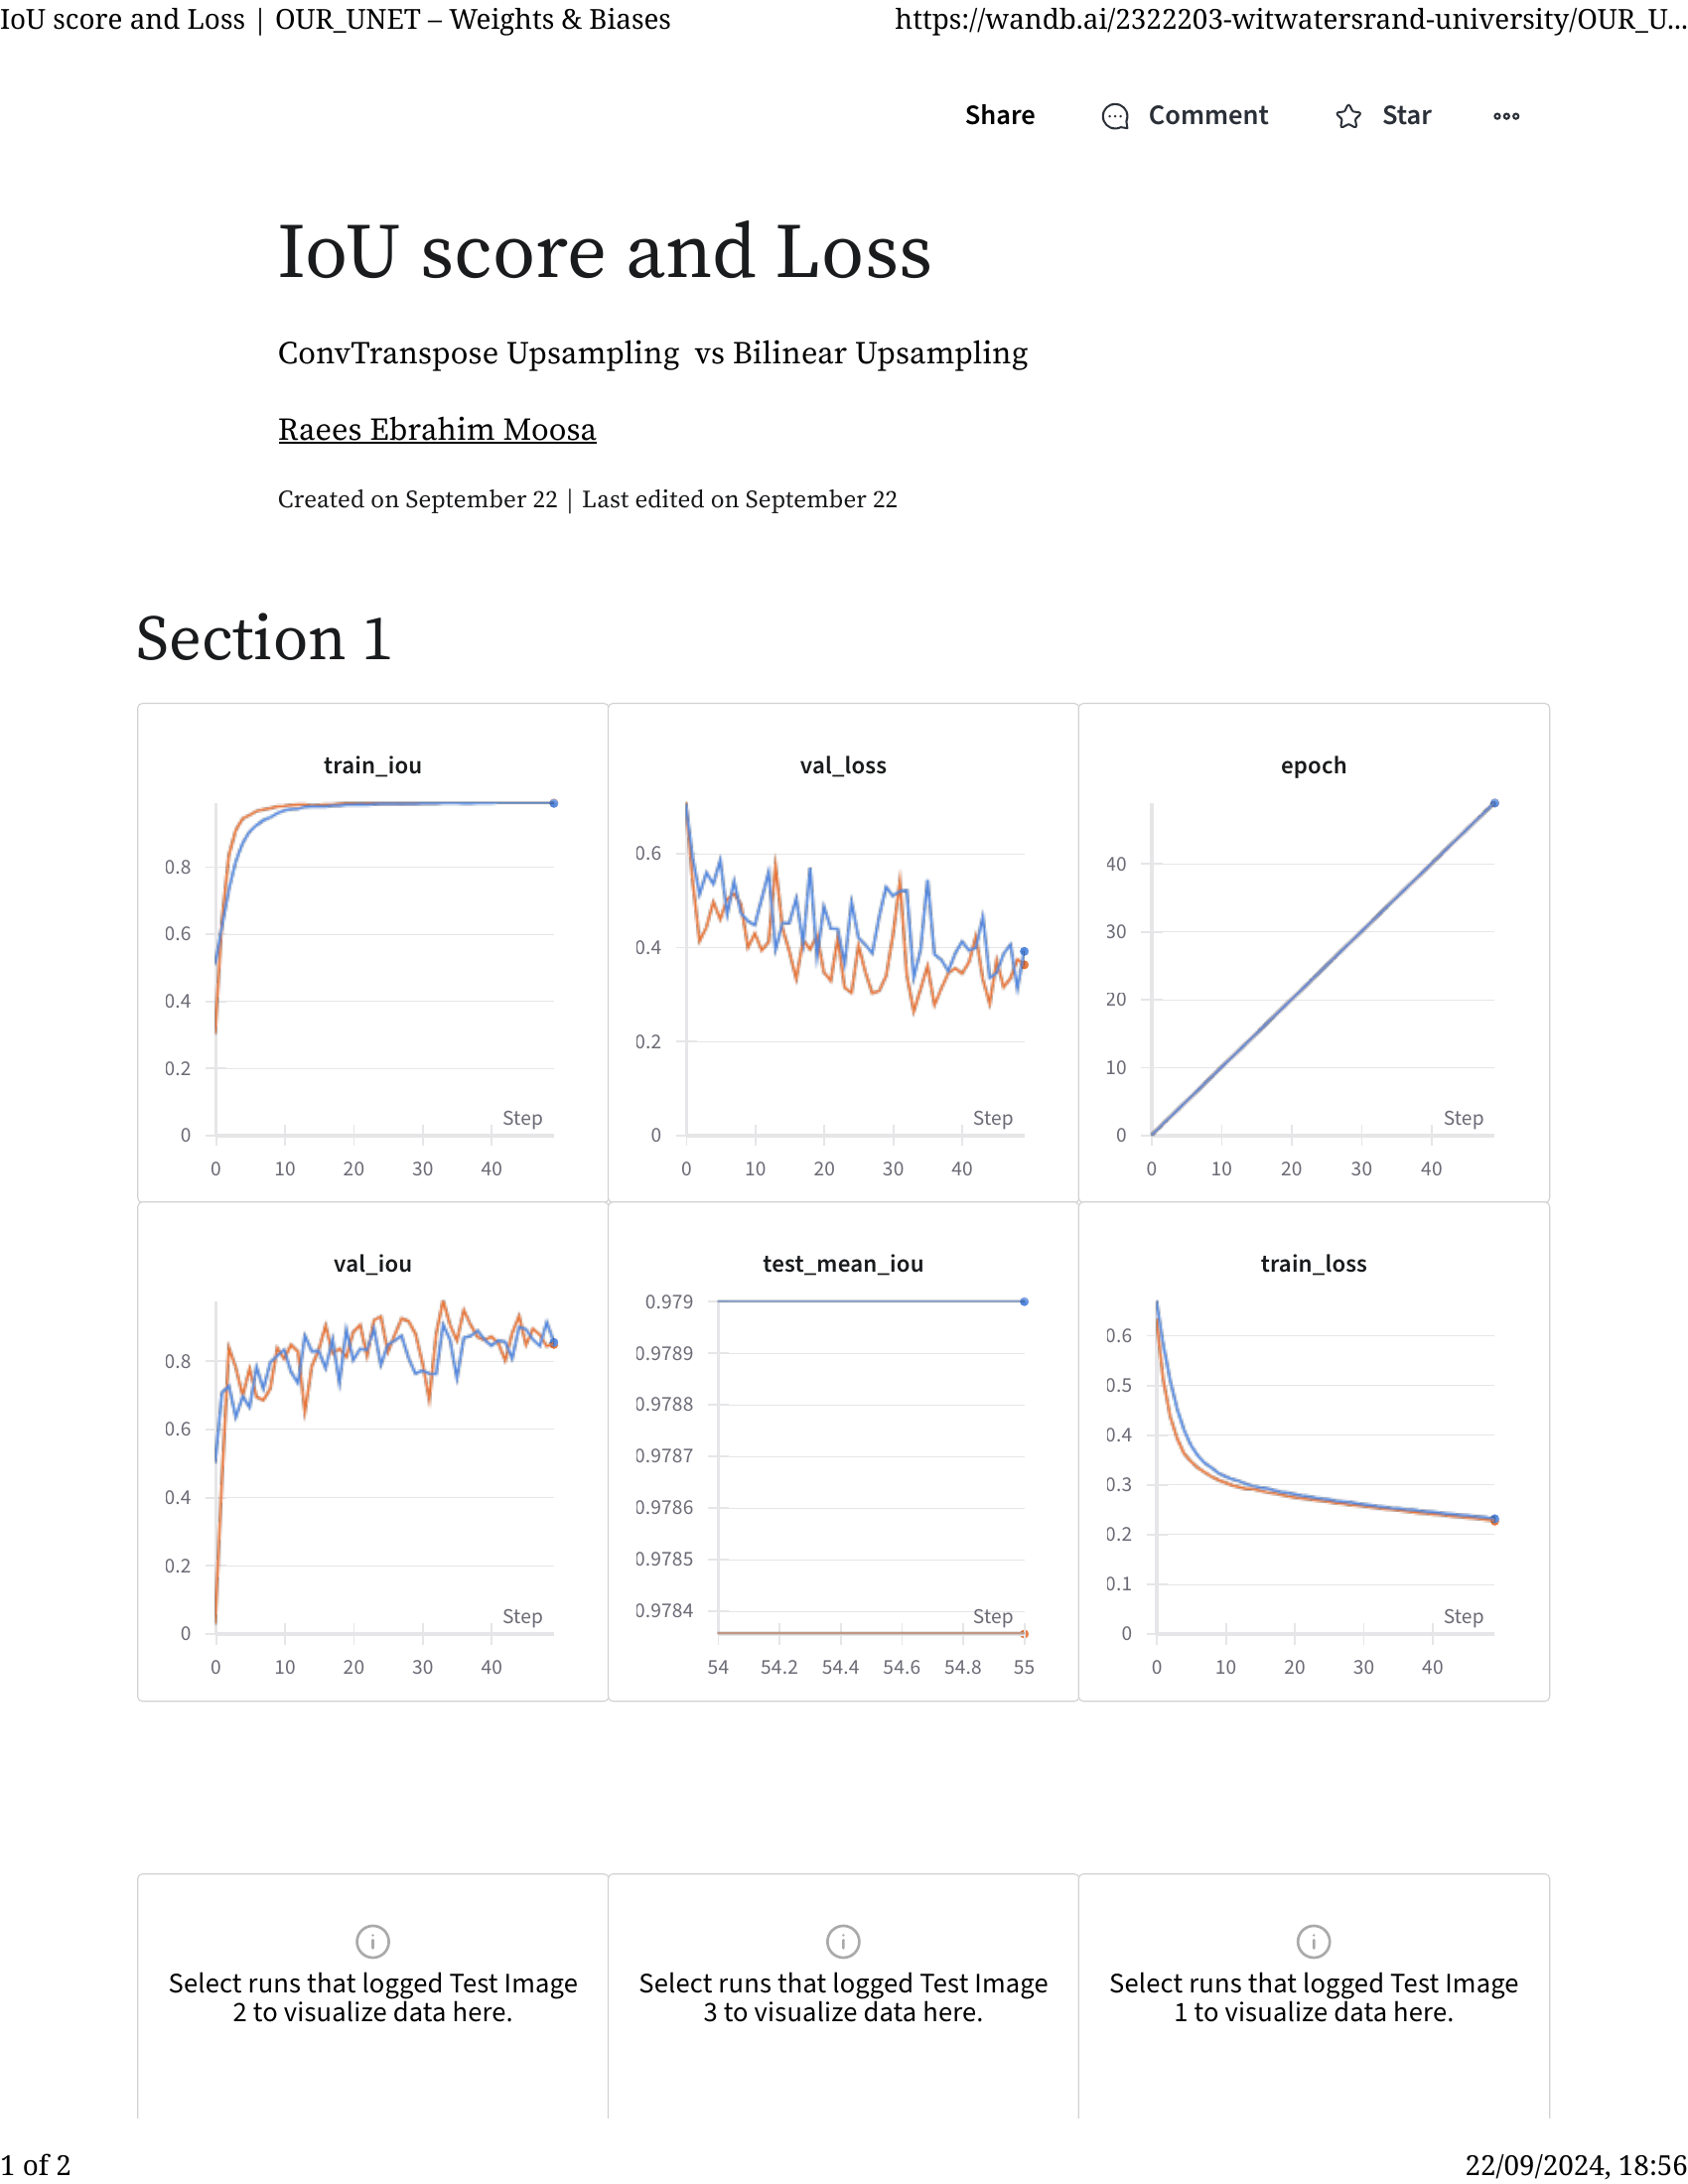

In [21]:

from pdf2image import convert_from_path
from IPython.display import display

images = convert_from_path('./wandb_logs/IoU score and Loss _ OUR_UNET – Weights & Biases.pdf')

for image in images:
    display(image)


# 4 Other architectures

NOTE refer to notebooks 
- `Unet_variants.ipynb` and \
- `deeplabV3.ipynb` \
to run and see the other models 

## unet variants
1. Resnet34
2. VGG11
3. mobileone-v2

## DeeplabV3 variants
1. Resnet34
2. ResNeXt50
3. TimmRegNetX 
# The outputs collected from the different backbone architectures are presented here


## DeepLab V3 variants: ouputs

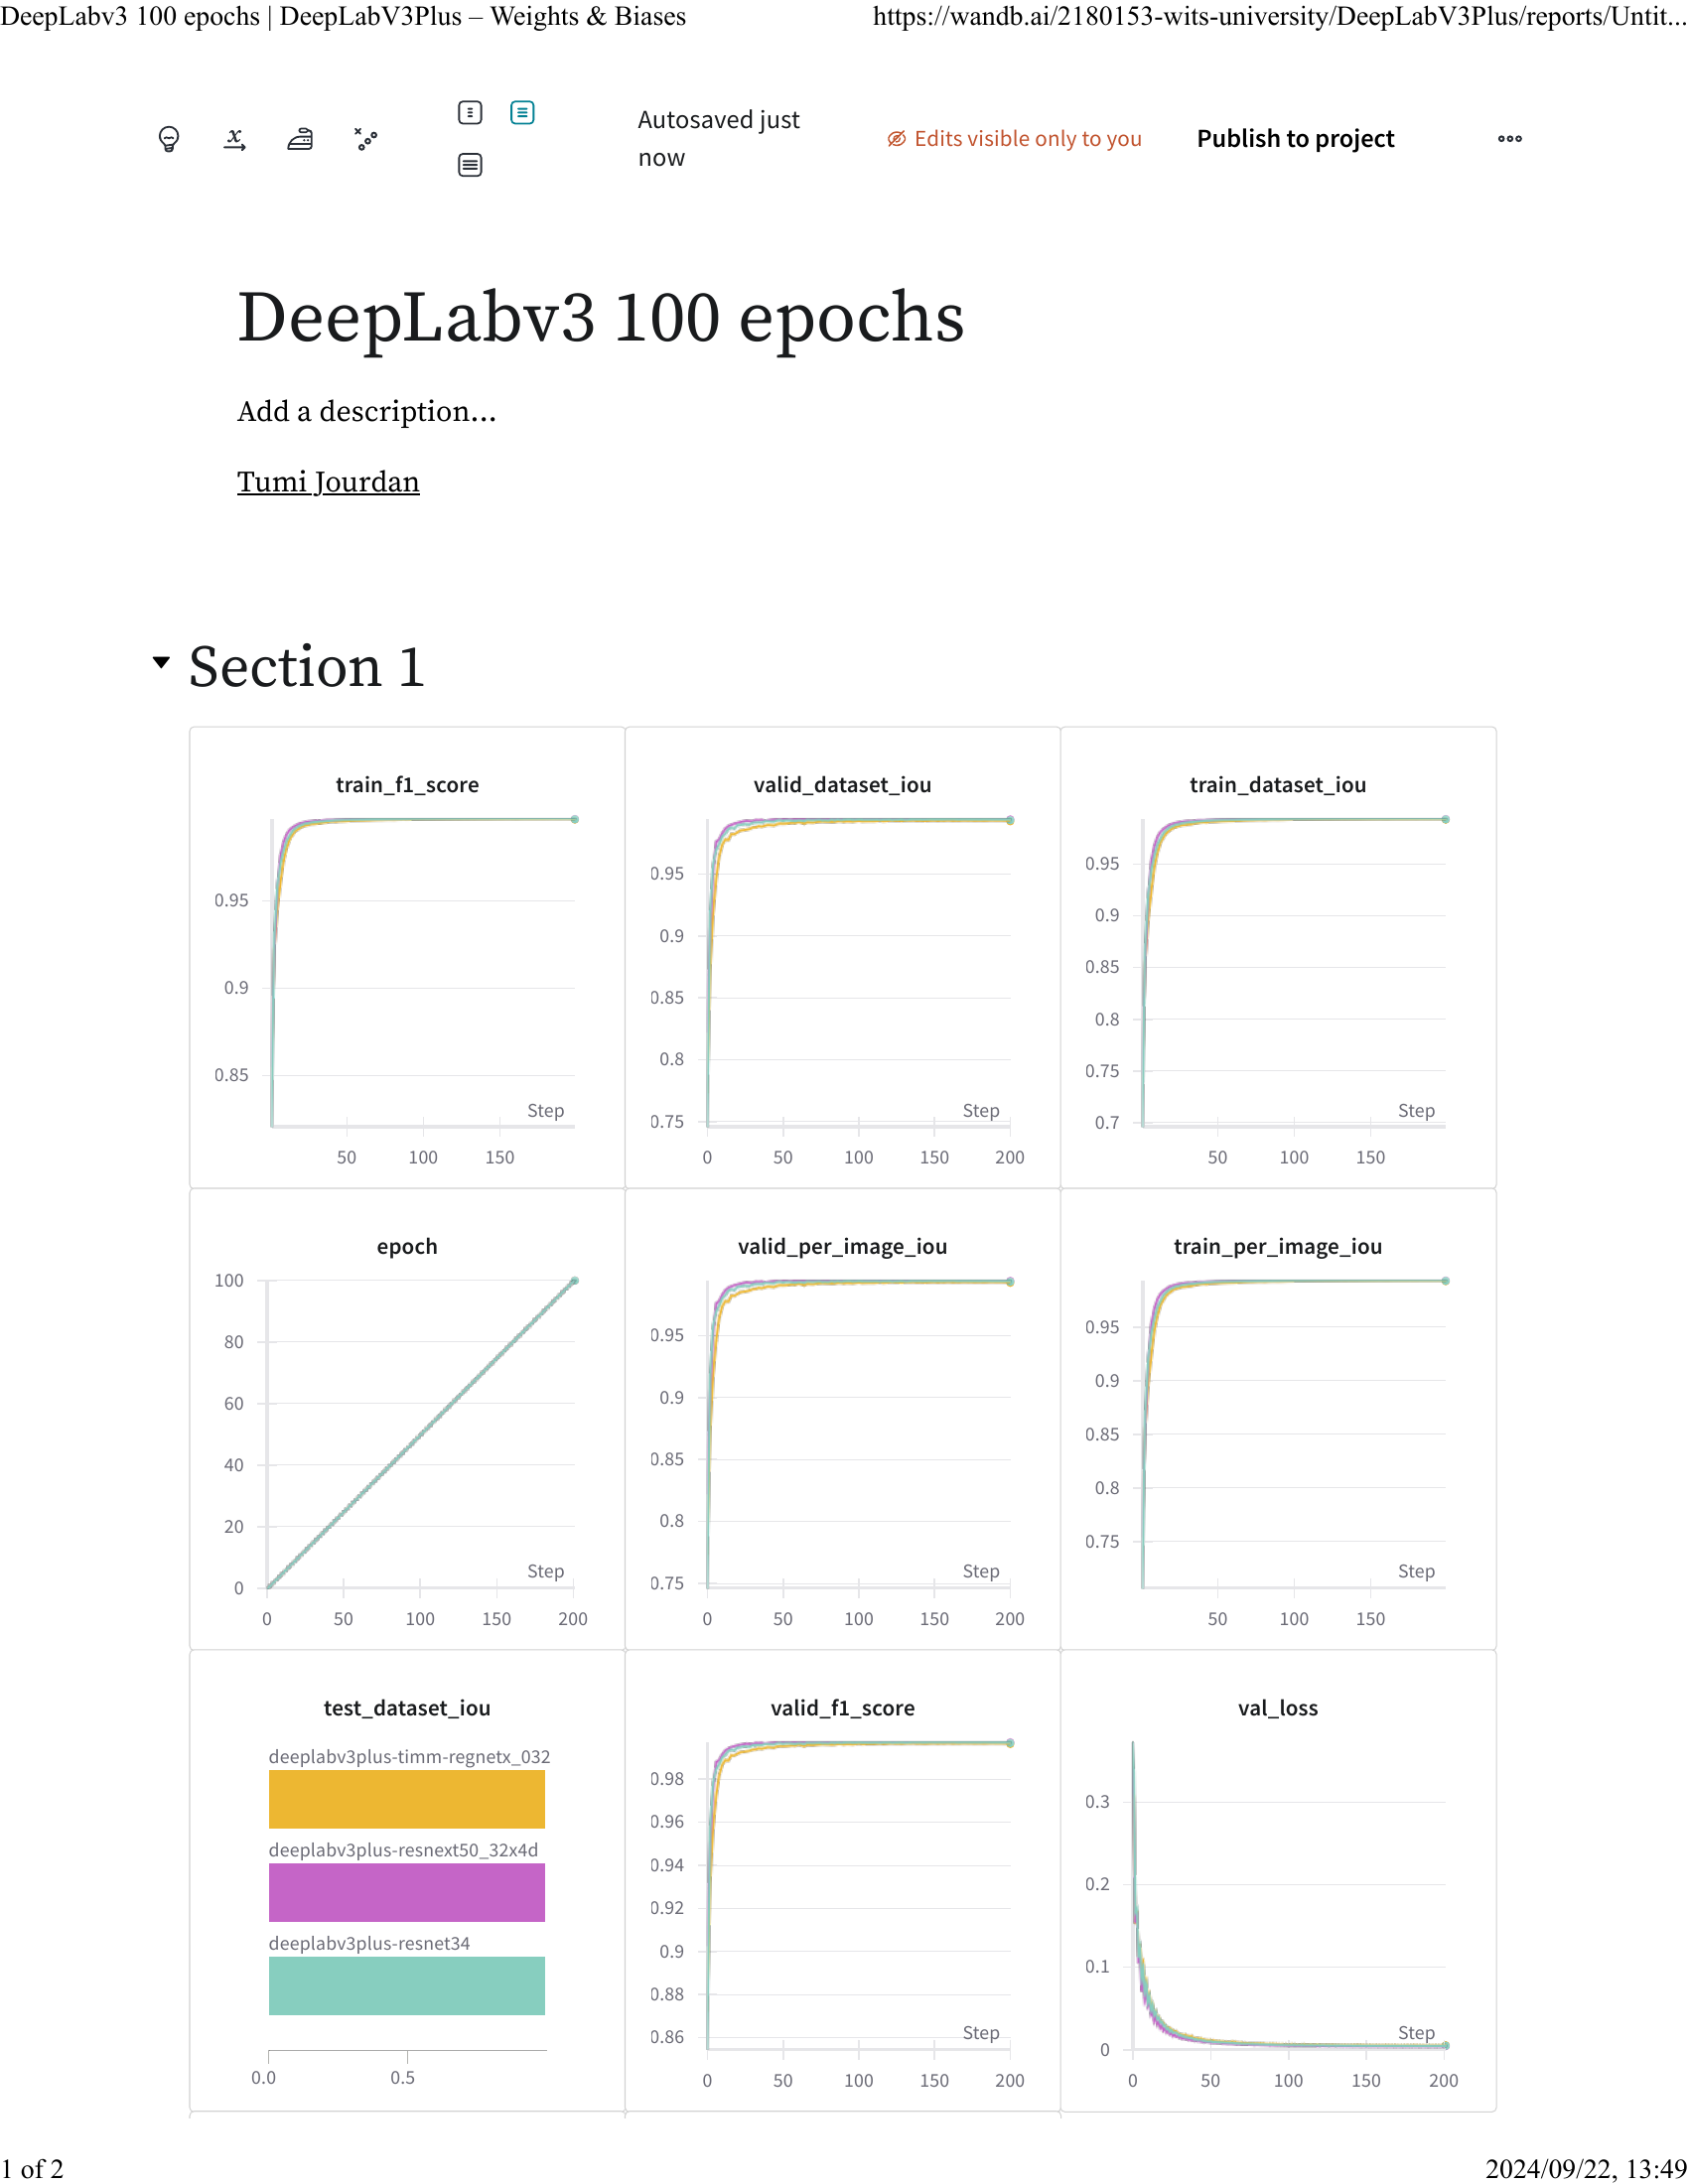

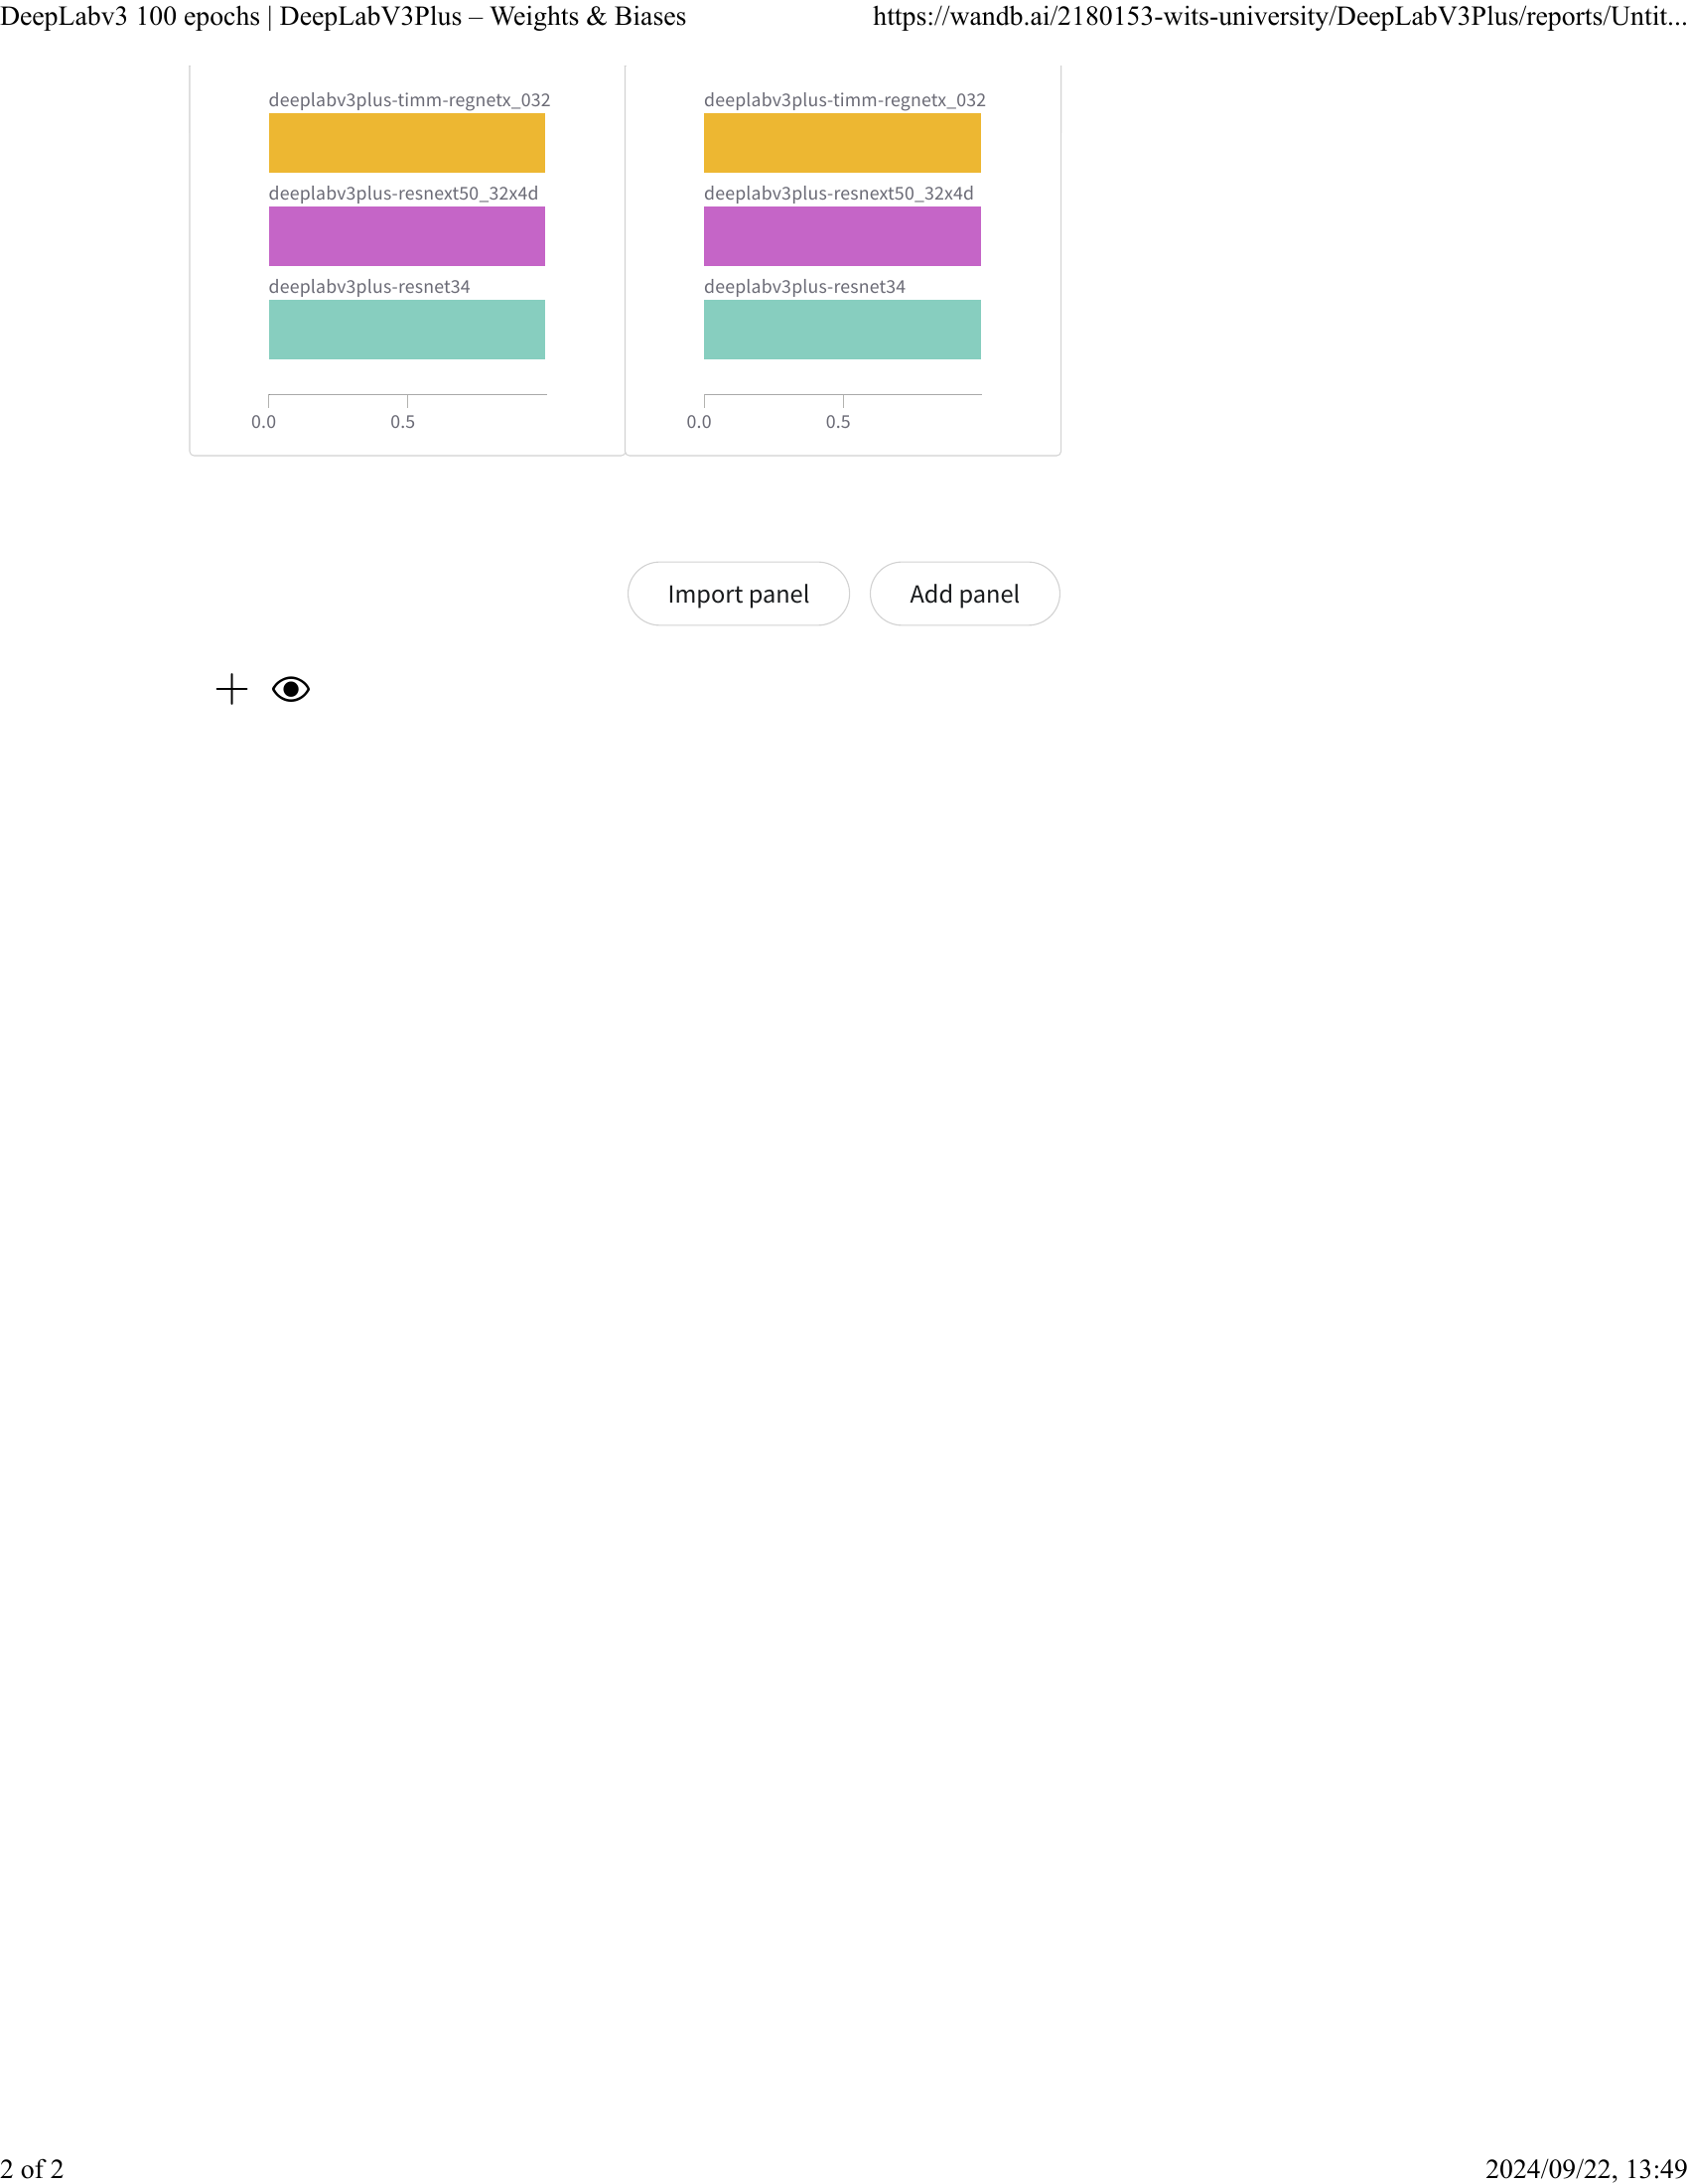

In [22]:



images = convert_from_path('./wandb_logs/DeepLabv3 100 epochs _ DeepLabV3Plus – Weights & Biases.pdf')


for image in images:
    display(image)

# Comparison of Metrics between the models
- for the different masks produced refer to the respective notebooks to see the outputs

 ## Tabulated performance
 - refer to the above graphs for the N/A for deeplab!

| Model Variant               | Mean IoU | Mean Accuracy | Mean Precision | Mean Recall | Mean F1 Score |
|-----------------------------|----------|---------------|----------------|-------------|----------------|
| ConvTranspose (Variant 1)   | 0.9765   | 0.9939        | 0.9883         | 0.9878      | 0.9881         |
| Bilinear (Variant 2)        | 0.9787   | 0.9945        | 0.9842         | 0.9943      | 0.9892         |
| ResNet34 - DeepLab          | 0.99392  | N/A           | N/A            | N/A         | 0.99695        |
| ResNeXt50 - DeepLab         | 0.99426  | N/A           | N/A            | N/A         | 0.99712        |
| RegNetX 032 - DeepLab       | 0.99275  | N/A           | N/A            | N/A         | 0.996          |
| Unetplus - ResNet           | 0.9860   | 0.9964        | 0.9915         | N/A         | 0.9929         |
| Unetplus - VGG              | 0.9743   | 0.9932        | 0.9752         | N/A         | 0.9870         |


# Section 5

## Overfitting on The Unet baselines
- For the Bilinear Upsampling, we notice the  validation loss starts top increase after its lowest point at epoch 35, this would suggest that the model is over fitting to the training dataset after this point in training.
    -  when performing inference on the testing dataset  we load the model from the epoch at which the validation loss was at its lowest, and then calculated the evaluation metrics
- Similarly for the transpose convolution model we notice overfitting on the training set before applying rotational transformations to the training images - this is believed to be caused by the consistent shadow gradient of the background resulting in the puzzle foreground bleeding into the background as shown below

[image of weird background-foreground bleeding](https://imgur.com/a/lQRL9Vo)

to deal with the overfitting we increases the dataset size and only saved the model checkpoints when the validation loss was at its lowest compared to the previous lowest validation lost.

## Comments on Unet Baselines

- [performance of baselines](https://imgur.com/a/oU3akZ8)

### Insights on model performance
- During training we use a sigmoid instead of a softmax in the output layer of the Unet, because using the argamx with the softmax is not differentiable which was not allowing the model to do backprop and train correctly i.e. `nan` loss values and `nan` predictions were being output
- Adding gradient clipping to the model training loop to avoid exploding/vanishing gradients
- The Adams Optimiser was reduced to $1e-5$ to allow for stability in the model training
 

### Challenges faced
- Limited training data - Increased the training dataset size size by performing transformations (rotation, horizontal & vertical flips) on the existing images.
- Jupyter Notebook - GPU VRAM was held hostage by the notebook, training the models required garbage collection and careful management of what was loaded in the GPU VRAM at a given time (models+datasets loaded and offloaded) 
- Bilinear model wasn't upscaling through bottleneck correctly; had to multiply the output channels in the upsampling by 2 to get it to match the input channels of the next layer in the upsampling process.

## Comments on the Unet Variants
Unet Variants
- Used Resnet, VGG and Mobileone variants to UNet
1. ResNet variant performs the best with slightly better testing ious(0.986), accuracies(0.996) and f1_scores(0.993)
2. Training for all variants best performed at ~35 epochs

Challenges
- Memory for all 3 variants is considerably large.
- Tried training an EfficientNet variant which was too slow to train


## Comments on the DeepLabV3
Deep lab and all of the variants chosen perform similarly. This is most probably due to similar parameter sizes selected. 
When we attempted to use encoders with parameters much larger than 22M, 100% of the gpus vram would be used , stalling the training process. 

To attempt to overfit the models we ran them with 100 epochs. There were no issues, and training remained stable and converging to around a 0.0047 validation loss.